# Business Problem

Cadio Catch Diseases é uma empresa especializada em detecção de doenças cardíacas em estágios iniciais. O seu modelo de negócio é do tipo Serviço, ou seja, a empresa ofereço o diagnóstico precoce de uma doença cardiovascular por um certo preço.
Atualmente, o diagnóstico de uma doença cardiovascular é feita manualmente por uma equipe de especialistas.A precisão atual do diagnóstico varia entre 55% e 65%, devido a complexidade do diagnóstico e também da fadiga da equipe que se revezam em turnos para minimizar os riscos. O custo de cada diagnóstico, incluindo os aparelhos e a folha de pagamento dos analistas, gira em torno de R$ 1.000,00.
O preço do diagnóstico, pago pelo cliente, varia de acordo com a precisão conseguida pelo time de especialistas, o cliente paga R$500,00 a cada 5% de acurácia acima de 50%. Por exemplo, para uma precisão de 55%, o diagnóstico custa R$500,00 para o cliente, para uma precisão de 60%, o valor é de R$ 1000,00 e assim por diante. Se a precisão do diagnóstico for 50% o cliente não paga por ele.

Observe que a variação da precisão dada pelo time de especialistas, faz com que a empresa tenha ora uma operação com lucro, receita maior que o custo, ora uma operação com prejuízo, receita menor que o custo. Essa instabilidade do diagnóstico faz com que a empresa tenha um Cashflow imprevisível.
O seu objetivo como o Cientista de Dados contratado pela Cardio Catch Diseases é criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnósticos.
Portanto o seu trabalho como Data Scientist é criar um ferramenta de classificação de doentes, como umaprecisão estável. Junto com a ferramenta, você precisa enviar um relatório para o CEO da Cardio Catch Diseases, reportando os resultados e respondendo às seguintes perguntas: 

1. Qual a Acurácia e a Precisão da ferramenta?
2. Quanto lucro a Cardio Catch Diseases passará a ter com a nova ferramenta?
3. Qual a Confiabilidade do resultado dados pela nova ferra enta?

#### Dados

- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men 
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

# Set up

### Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import chi2_contingency, pointbiserialr
from dython      import nominal

from sklearn                 import model_selection  as ms
from matplotlib              import pyplot as plt
from IPython.display         import HTML
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble        import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost                 import XGBClassifier
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier, BaggingClassifier
from sklearn.metrics         import accuracy_score, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes     import GaussianNB
from lightgbm                import LGBMClassifier


### Functions

In [3]:
# Formatar os valores da pressão arterial
def format_pressure(value):
    if value == 1:
        return value * 100.00
    elif 2 <= value <= 20:
        return value * 10.00
    elif 30 <= value <= 240:
        return float(value)
    elif 241 <= value <= 2088:
        return value / 10.00
    else:
        return value / 100.00
    
    
    # Definir intervalo de IMC em categorias
def health(value):
    if value <= 16.9:
        return 0
    elif 17 <= value <= 20:
        return 1
    elif 21 <= value <= 24:
        return 2
    elif 25 <= value <= 29:
        return 3
    elif 30 <= value <= 35:
        return 4
    else:
        return 5
    

    # Definir intervalo de PA em categorias
def pa(value1, value2):
    if value1 <= 80 and value2 <= 40:
        return 0
    elif value1 <= 120 and value2 <= 80:
        return 1
    elif value1 <= 129 and value2 <= 84:
        return 2
    elif value1 <= 139 and value2 <= 89:
        return 3
    elif value1 <= 159 and value2 <= 99:
        return 4
    elif value1 <= 179 and value2 <= 109:
        return 5
    else:
        return 6


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    kcorr = max(1, k - (k-1)**2/(n-1))
    rcorr = max(1, r - (r-1)**2/(n-1))
    
    if kcorr == 1 or rcorr == 1:
        return 0
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

## ETL

### Import Data

In [5]:
df_train_raw = pd.read_csv('cardio_train.csv', sep=';') 

### Data Raw status

In [6]:
df1 = df_train_raw.copy()

In [7]:
df1.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1


In [8]:
df1.info()

# Types = ok
# Rename Columns (snakecase): ok
# Fillout NaN: ok 
# Rows:70000 
# Cols: 13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### Changing Data

In [9]:
# age - Change to years
df1['age'] = round(df1['age'].apply(lambda x: x / 365.25 ), 0)
df1['age'] = df1['age'].astype(int)


# Formatando pressão arterial
df1['ap_lo'] = df1['ap_lo'].map(format_pressure)
df1['ap_hi'] = df1['ap_hi'].map(format_pressure)



In [10]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110.0,80.0,1,1,0,0,1,0
1,1,55,1,156,85.0,140.0,90.0,3,1,0,0,1,1
2,2,52,1,165,64.0,130.0,70.0,3,1,0,0,0,1
3,3,48,2,169,82.0,150.0,100.0,1,1,0,0,1,1
4,4,48,1,156,56.0,100.0,60.0,1,1,0,0,0,0


# Feature Engineering

A etapa de Feature Engineering foi colocada antes da EDA para ser possível a exploração de hipóteses que dependem de mais de 1 variável (IMC e Pressão Arterial)

In [11]:
df2 = df1.copy()
df_cat = df1.copy()

In [12]:
# Creating IMC - weight/height²
df2['imc'] = round(df2['weight'] / (df2['height'] ** 2) * 10000, 2)


## Health_status - Intervalos do IMC 
# magreza - < 16.9 - 0
# abaixo - 17 ~ 20 - 1
# normal - 20 ~ 24 - 2
# acima - 25 ~ 29 - 3
# obesidade - 30 ~ 35 - 4
# morbides - > 35 - 5
df2['imc_status'] = df2['imc'].map(health)


# Intervalos de PA segundo literatura: 

# baixa:       Hi <80  Lo <40 - 0
# Boa:         Hi <120 Lo <80 - 1
# normal:      Hi <129 Lo <84 - 2
# Elevada:     Hi <139 Lo <89 - 3
# estágio I:   Hi <159 Lo <99 - 4
# Estágio II:  Hi <179 Lo <109 - 5
# Estágio III: Hi >180 Lo >110 - 6
df2['pa_status'] = df2.apply(lambda row: pa(row['ap_hi'], row['ap_lo']), axis=1)

df_cat['gender'] = df_cat['gender'].apply( lambda x: 0 if x == 1 else 1)

In [13]:
# Alterando as variáveis categóricas para plotar no gráfico: 

soro_map = { 1: 'normal', 2: 'acima', 3: 'elevado'}

df_cat['cholesterol'] = df_cat['cholesterol'].map(soro_map)
df_cat['gluc'] = df_cat['gluc'].map(soro_map)
df_cat['smoke'] = df_cat['smoke'].apply( lambda x: 'nao' if x == 0 else 'sim')
df_cat['alco'] = df_cat['alco'].apply( lambda x: 'nao' if x == 0 else 'sim')
df_cat['active'] = df_cat['active'].apply( lambda x: 'nao' if x == 0 else 'sim')
df_cat['gender'] = df_cat['gender'].apply( lambda x: 'mulher' if x == 1 else 'homem')


def health_cat(value):
    if value <= 16.9:
        return 'magreza'
    elif 17 <= value <= 20:
        return 'abaixo'
    elif 21 <= value <= 24:
        return 'normal'
    elif 25 <= value <= 29:
        return 'acima'
    elif 30 <= value <= 35:
        return 'obesidade'
    else:
        return 'morbidade'
    
## Health_status - Intervalos do IMC 
# magreza - < 16.9 - 0
# abaixo - 17 ~ 20 - 1
# normal - 20 ~ 24 - 2
# acima - 25 ~ 29 - 3
# obesidade - 30 ~ 35 - 4
# morbides - > 35 - 5

# Creating IMC - weight/height²
df_cat['imc'] = round(df_cat['weight'] / (df_cat['height'] ** 2) * 10000, 2)

df_cat['imc_status'] = df_cat['imc'].map(health_cat)


# Intervalos de PA segundo literatura: 

# baixa:       Hi <80  Lo <40 - 0
# Boa:         Hi <120 Lo <80 - 1
# normal:      Hi <129 Lo <84 - 2
# Elevada:     Hi <139 Lo <89 - 3
# estágio I:   Hi <159 Lo <99 - 4
# Estágio II:  Hi <179 Lo <109 - 5
# Estágio III: Hi >180 Lo >110 - 6
    

    # Definir intervalo de PA em categorias
def pa_cat(value1, value2):
    if value1 <= 80 and value2 <= 40:
        return 'baixa'
    elif value1 <= 120 and value2 <= 80:
        return 'bom'
    elif value1 <= 129 and value2 <= 84:
        return 'normal'
    elif value1 <= 139 and value2 <= 89:
        return 'elevada'
    elif value1 <= 159 and value2 <= 99:
        return 'estagio_I'
    elif value1 <= 179 and value2 <= 109:
        return 'estagio_II'
    else:
        return 'estagio_III'
    
df_cat['pa_status'] = df_cat.apply(lambda row: pa_cat(row['ap_hi'], row['ap_lo']), axis=1)


In [14]:
df3 = df2.copy()

In [15]:
df_cat.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,imc,imc_status,pa_status
0,0,50,mulher,168,62.0,110.0,80.0,normal,normal,nao,nao,sim,0,21.97,normal,bom
1,1,55,homem,156,85.0,140.0,90.0,elevado,normal,nao,nao,sim,1,34.93,obesidade,estagio_I
2,2,52,homem,165,64.0,130.0,70.0,elevado,normal,nao,nao,nao,1,23.51,normal,elevada
3,3,48,mulher,169,82.0,150.0,100.0,normal,normal,nao,nao,sim,1,28.71,acima,estagio_II
4,4,48,homem,156,56.0,100.0,60.0,normal,normal,nao,nao,nao,0,23.01,normal,bom
5,8,60,homem,151,67.0,120.0,80.0,acima,acima,nao,nao,nao,0,29.38,morbidade,bom
6,9,61,homem,157,93.0,130.0,80.0,elevado,normal,nao,nao,sim,0,37.73,morbidade,elevada
7,12,62,mulher,178,95.0,130.0,90.0,elevado,elevado,nao,nao,sim,1,29.98,morbidade,estagio_I
8,13,48,homem,158,71.0,110.0,70.0,normal,normal,nao,nao,sim,0,28.44,acima,bom
9,14,54,homem,164,68.0,110.0,60.0,normal,normal,nao,nao,nao,0,25.28,acima,bom


# Exploratory Data Analysis

### Univariate Anaysis

#### Geral

In [16]:
# Número                                        'Categorias' - em forma numérica
# AGE: Média, mediana, min, max                 gender: 1 women, 2 men
# height: Média, mediana, min, max              cholesterol: 1 normal, 2 above, 3: high
# weight: Média, mediana, min, max              gluc:  1 normal, 2 above, 3 high
# ap_hi: Média, mediana, min, max               smoke: 1 yes, 0 no
# ap_lo: Média, mediana, min, max               alco: 1 yes, 0 no
#                                               active: 1 yes, 0 no

num_attributes = df_cat.select_dtypes( include=['int', 'float'])
cat_attributes = df_cat.select_dtypes( include = ['object'])

In [17]:
#Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion -std, min, max, range, skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( np.min )).T
d3 = pd.DataFrame( num_attributes.apply( np.max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew()  )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.00,99999.00,99999.0,49972.419900,50001.500,28851.096242,-0.001278,-1.198374
1,age,30.00,65.00,35.0,53.303157,54.000,6.760122,-0.306468,-0.821042
2,height,55.00,250.00,195.0,164.359229,165.000,8.210068,-0.642187,7.943653
3,weight,10.00,200.00,190.0,74.205690,72.000,14.395654,1.012070,2.586825
4,ap_hi,-1.50,240.00,241.5,126.979076,120.000,17.169958,0.855635,2.101024
5,ap_lo,-0.70,208.80,209.5,81.659033,80.000,10.235389,0.850847,9.013562
6,cardio,0.00,1.00,1.0,0.499700,0.000,0.500000,0.001200,-2.000056
7,imc,3.47,298.67,295.2,27.556560,26.375,6.091364,7.728847,221.232148


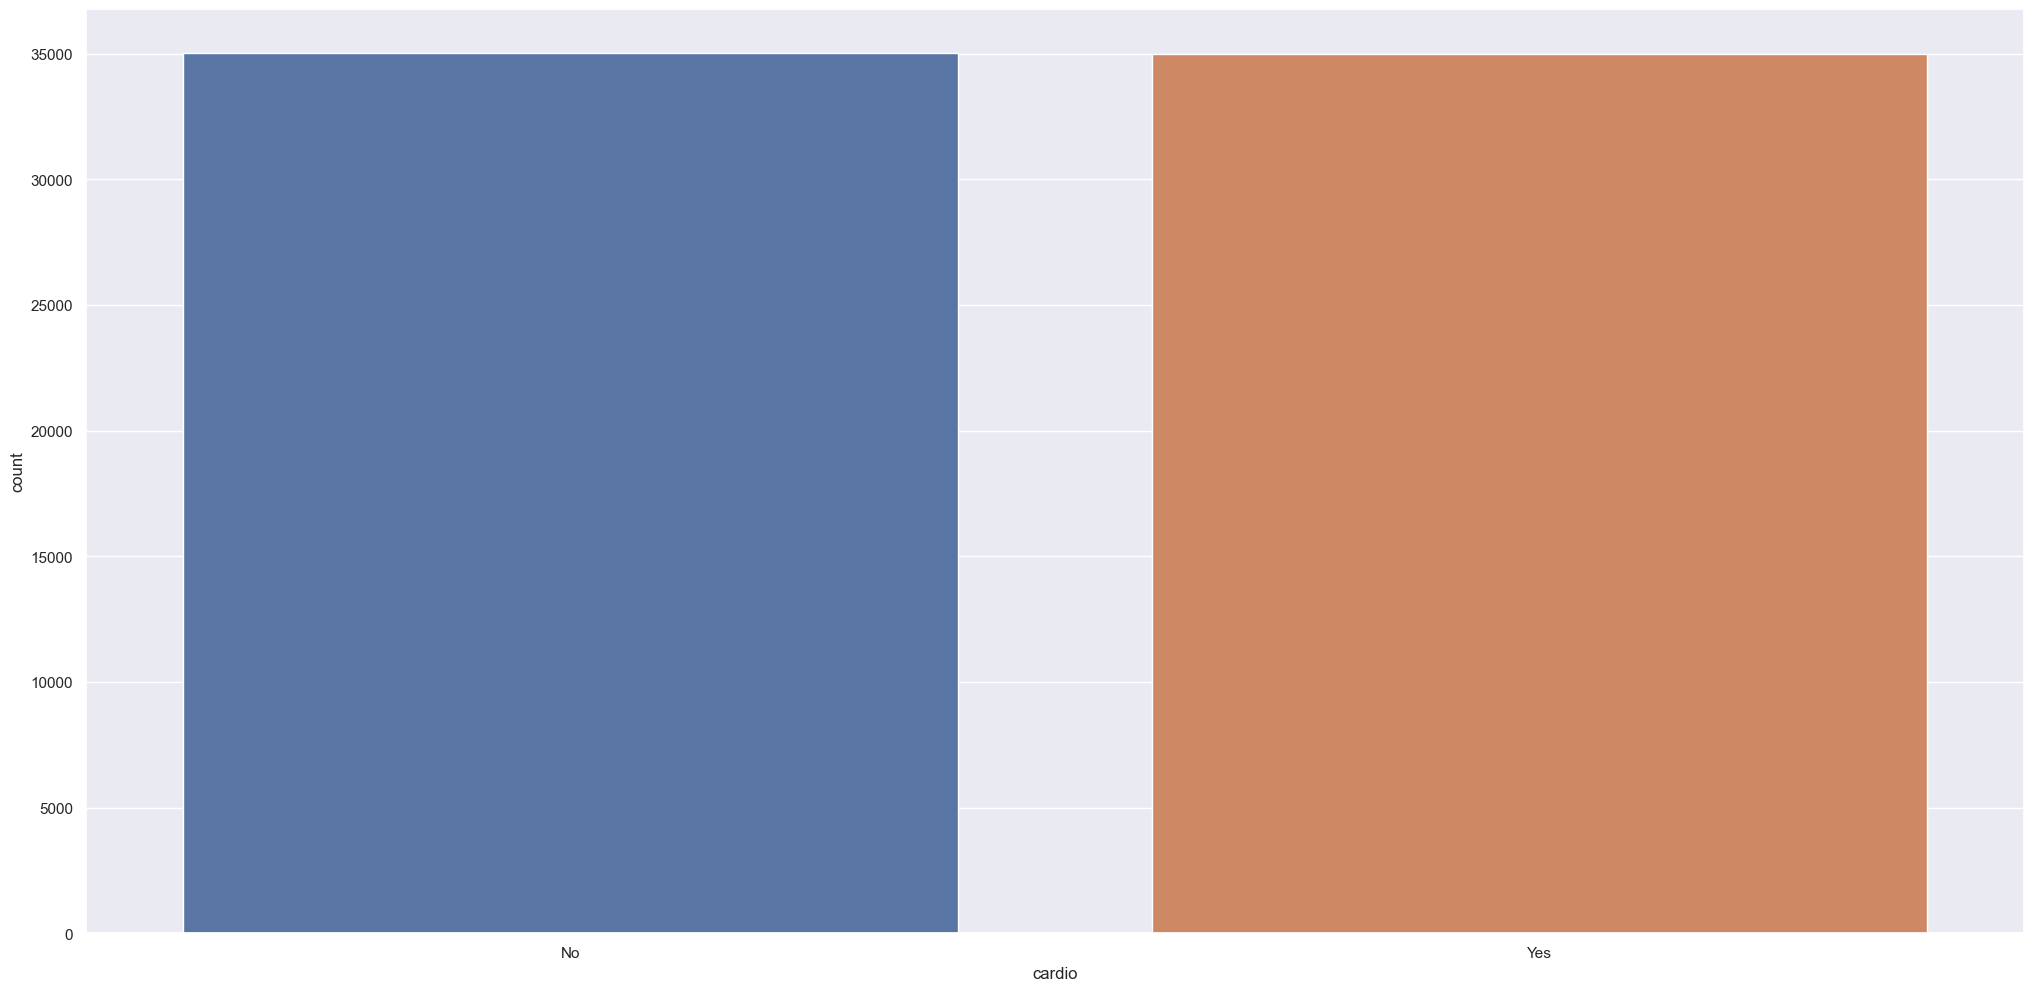

In [18]:
# counts each class for the target var
_ = sns.countplot(x=df2['cardio'])

# sets plot features
plt.xticks(ticks=[0,1], labels=['No','Yes'])

# displays the plot
plt.show()

#### Graf num

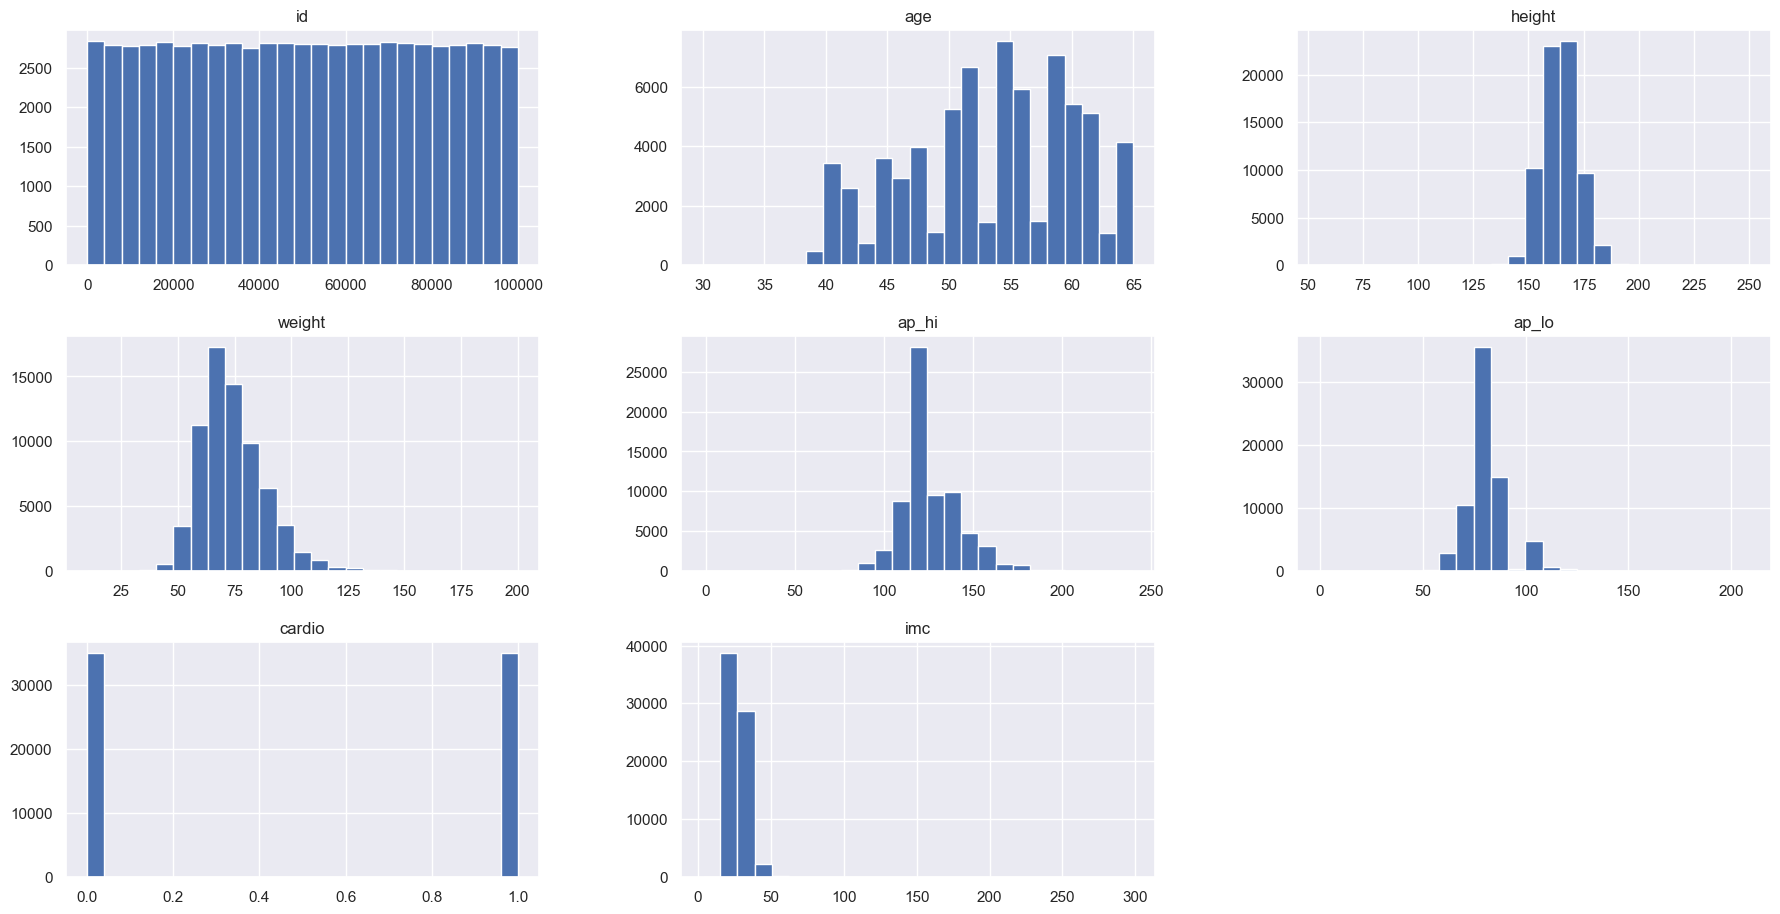

In [19]:
num_attributes.hist( bins=25, figsize=(22,11) );

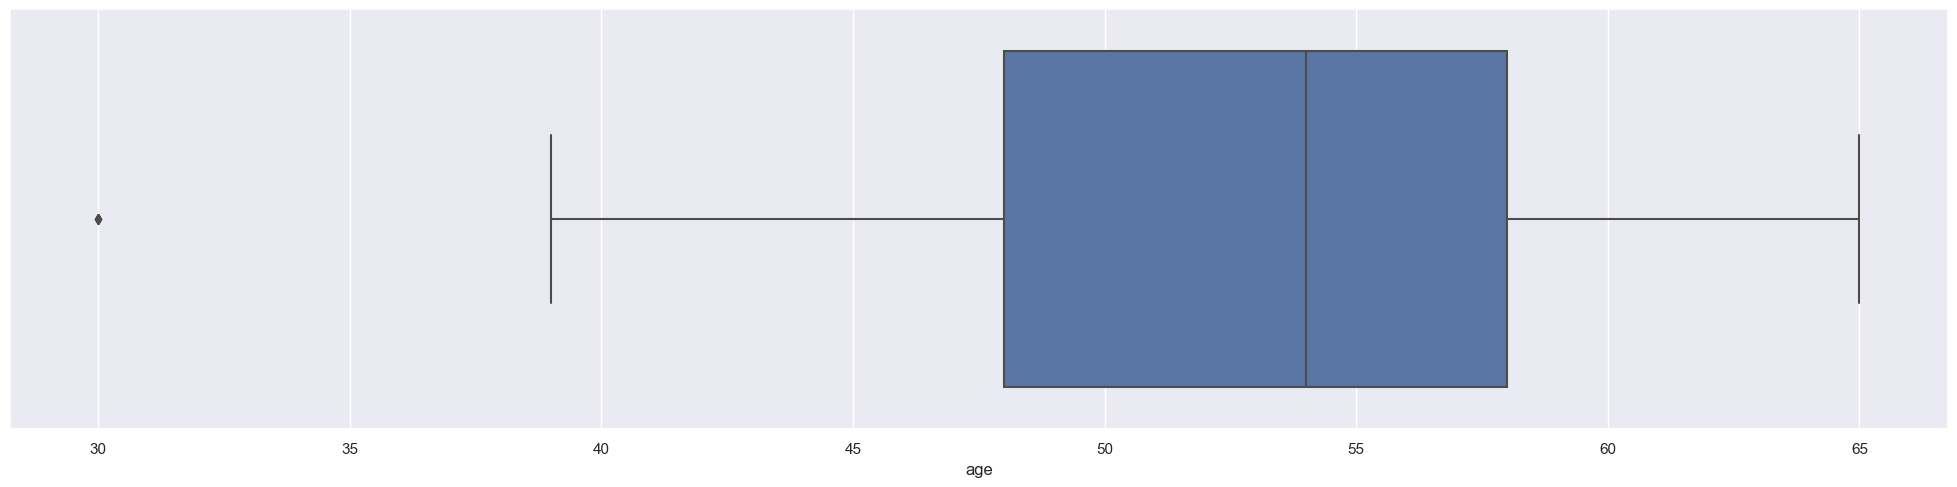

In [20]:
plt.subplot(2, 1, 1)
sns.boxplot(x='age',  data=df2);

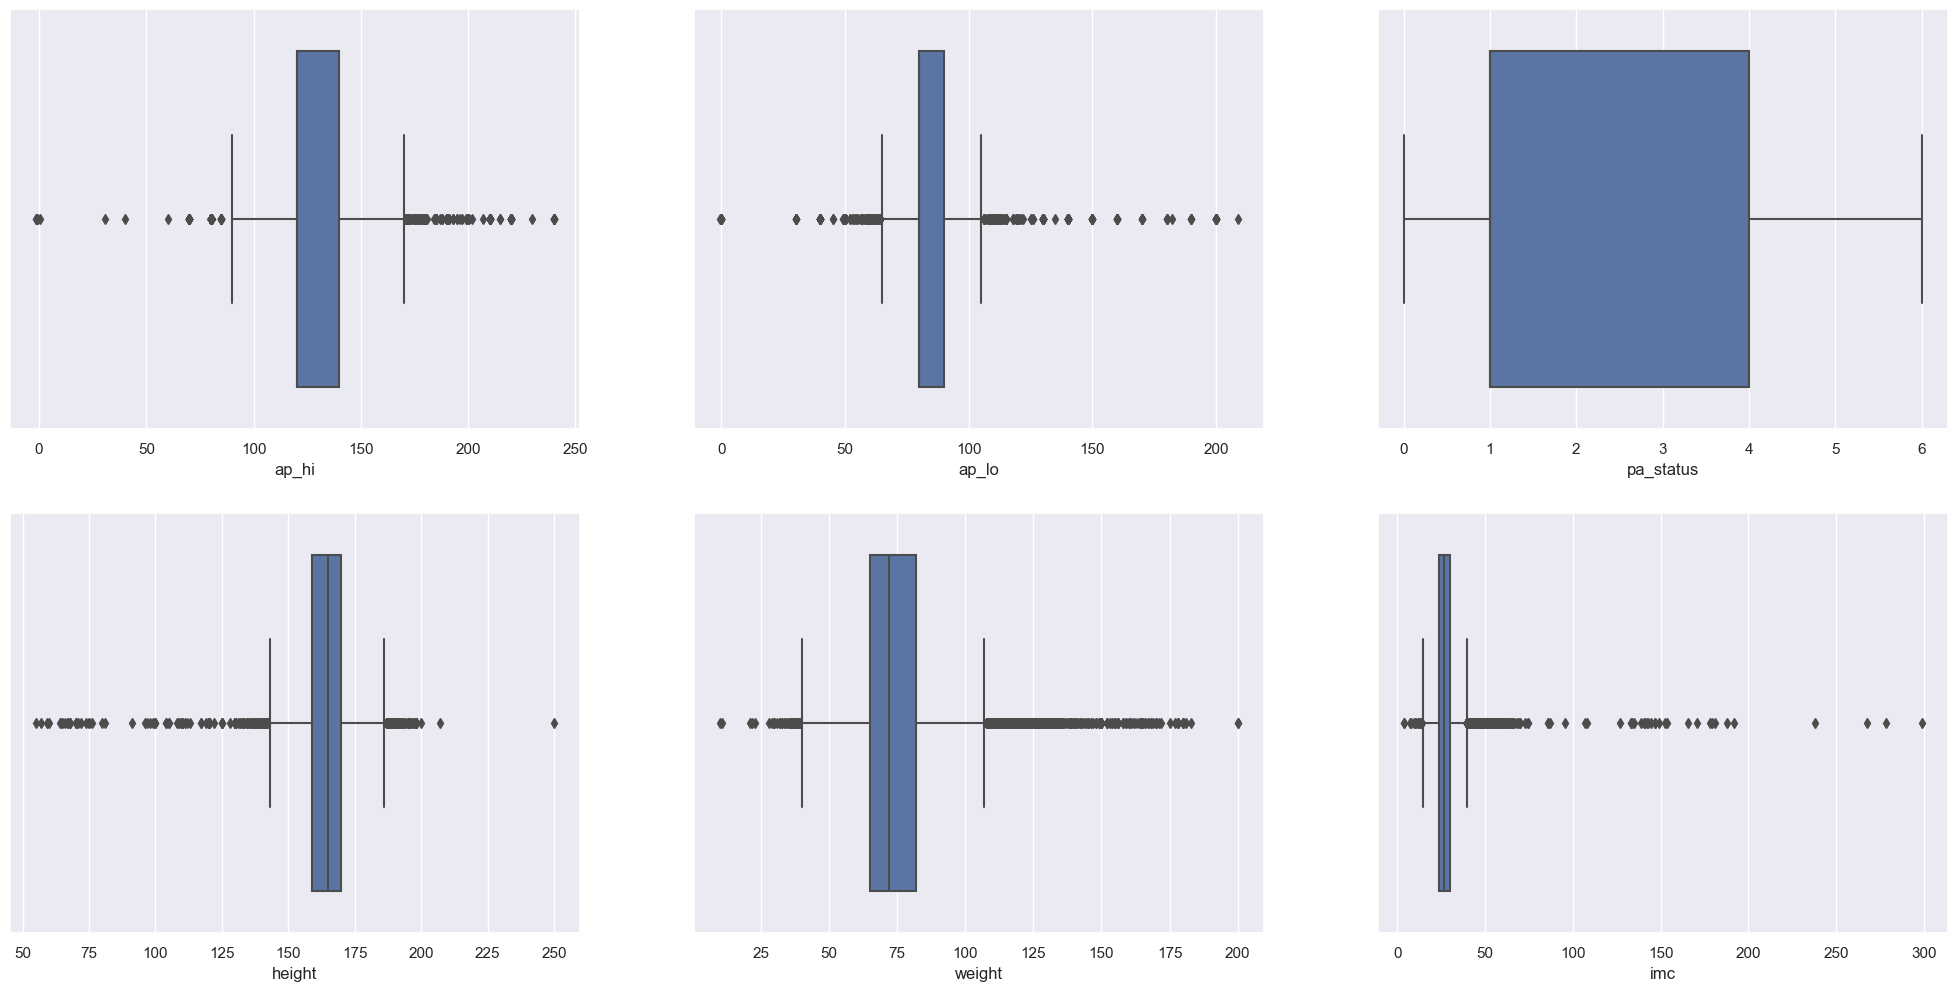

In [21]:
# PA

plt.subplot(2, 3, 1)
sns.boxplot(x='ap_hi',  data=df2);

plt.subplot(2, 3, 2)
sns.boxplot(x='ap_lo',  data=df2);

plt.subplot(2, 3, 3)
sns.boxplot(x='pa_status',  data=df2);

# cm - <130 > 200
plt.subplot(2, 3, 4)
sns.boxplot(x='height',  data=df2);

# KG - <40 > 200
plt.subplot(2, 3, 5)
sns.boxplot(x='weight',  data=df2);

plt.subplot(2, 3, 6)
sns.boxplot(x='imc',  data=df2);



#### Categorical Analysis

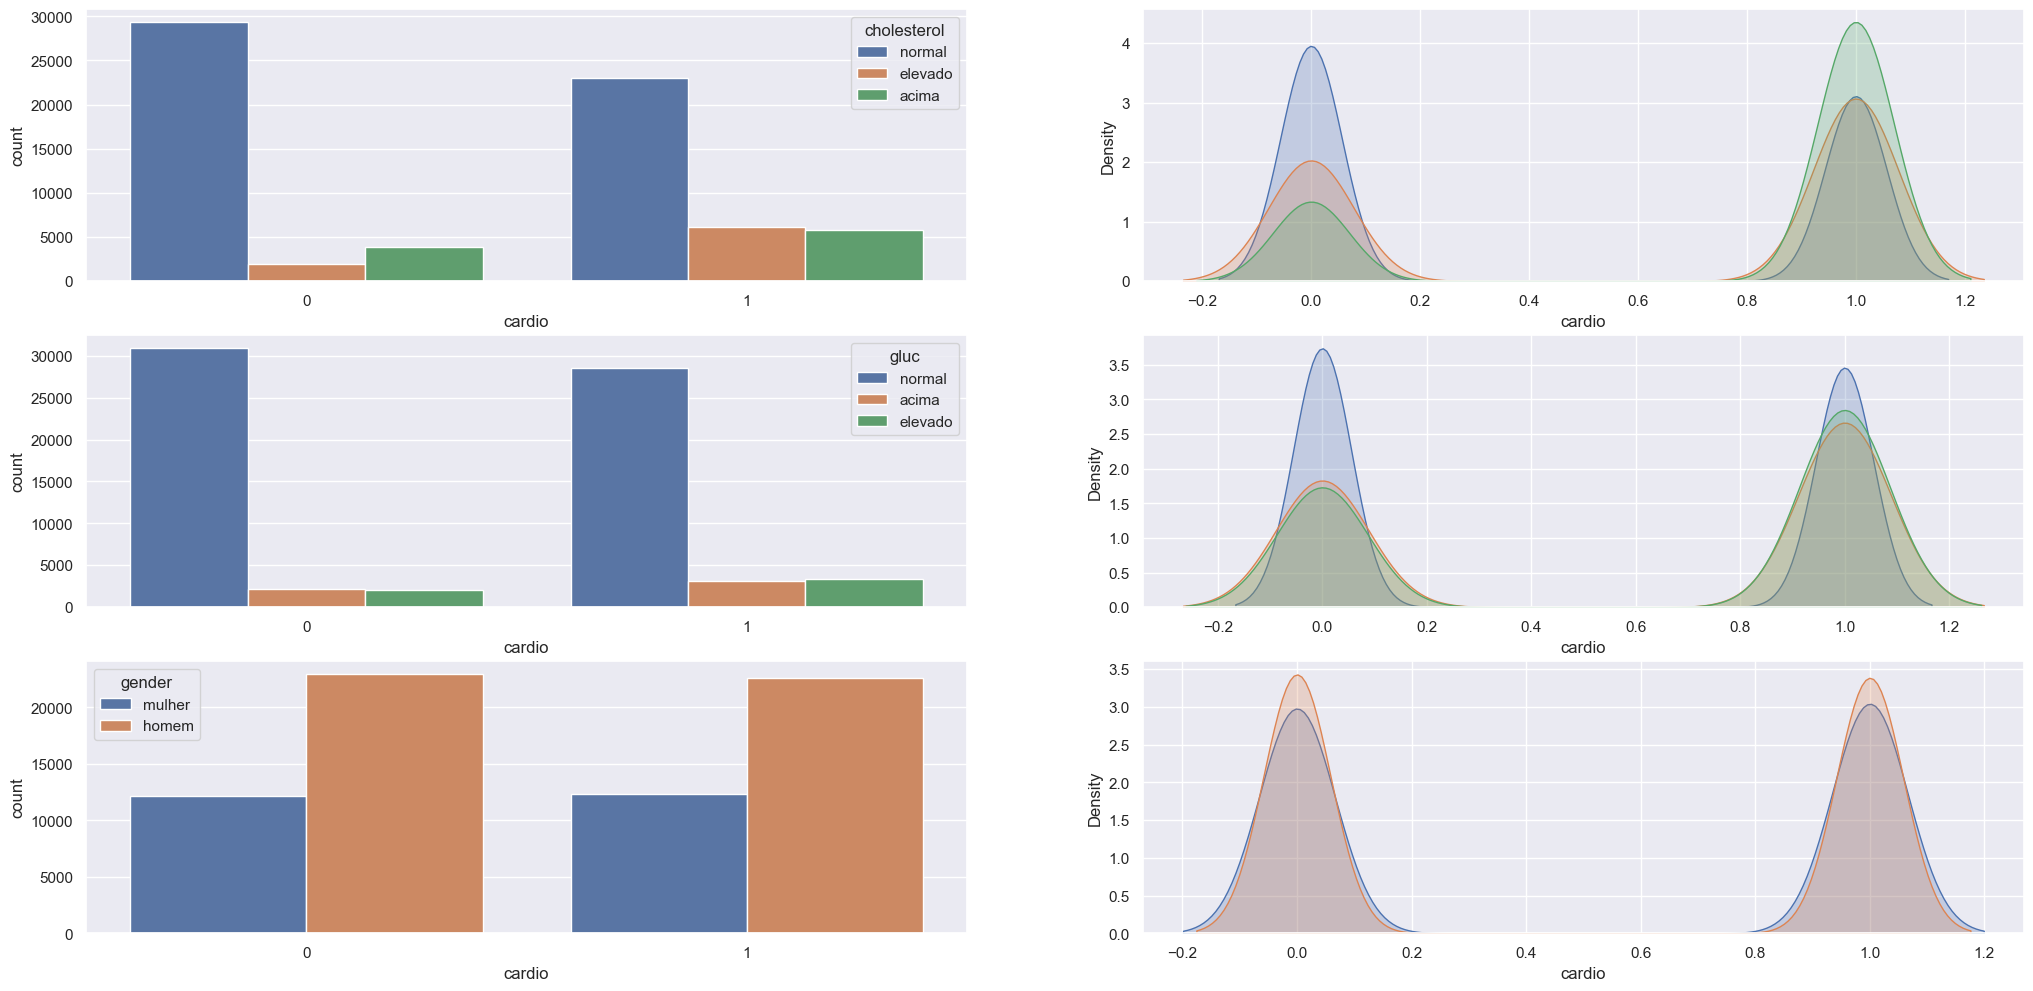

In [22]:
# soro_map = { 1: 'normal', 2: 'acima', 3: 'elevado'}

plt.subplot( 3, 2, 1)
sns.countplot(
    x='cardio',
    hue=('cholesterol'),
    data=df_cat,
);

plt.subplot( 3, 2, 2 )
sns.kdeplot( df_cat[df_cat['cholesterol'] == 'normal']['cardio'],  fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['cholesterol'] == 'acima']['cardio'],  fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['cholesterol'] == 'elevado']['cardio'],  fill=True, legend=True );

plt.subplot( 3, 2, 3)
sns.countplot(
    x='cardio',
    hue=('gluc'),
    data=df_cat,
);

plt.subplot( 3, 2, 4 )
sns.kdeplot( df_cat[df_cat['gluc'] == 'normal']['cardio'],  fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['gluc'] == 'acima']['cardio'],  fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['gluc'] == 'elevado']['cardio'],  fill=True, legend=True );

plt.subplot( 3, 2, 5)
sns.countplot(
    x='cardio',
    hue=('gender'),
    data=df_cat,
);

plt.subplot( 3, 2, 6 )
sns.kdeplot( df_cat[df_cat['gender'] == 'mulher']['cardio'],  fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['gender'] == 'homem']['cardio'],  fill=True, legend=True );


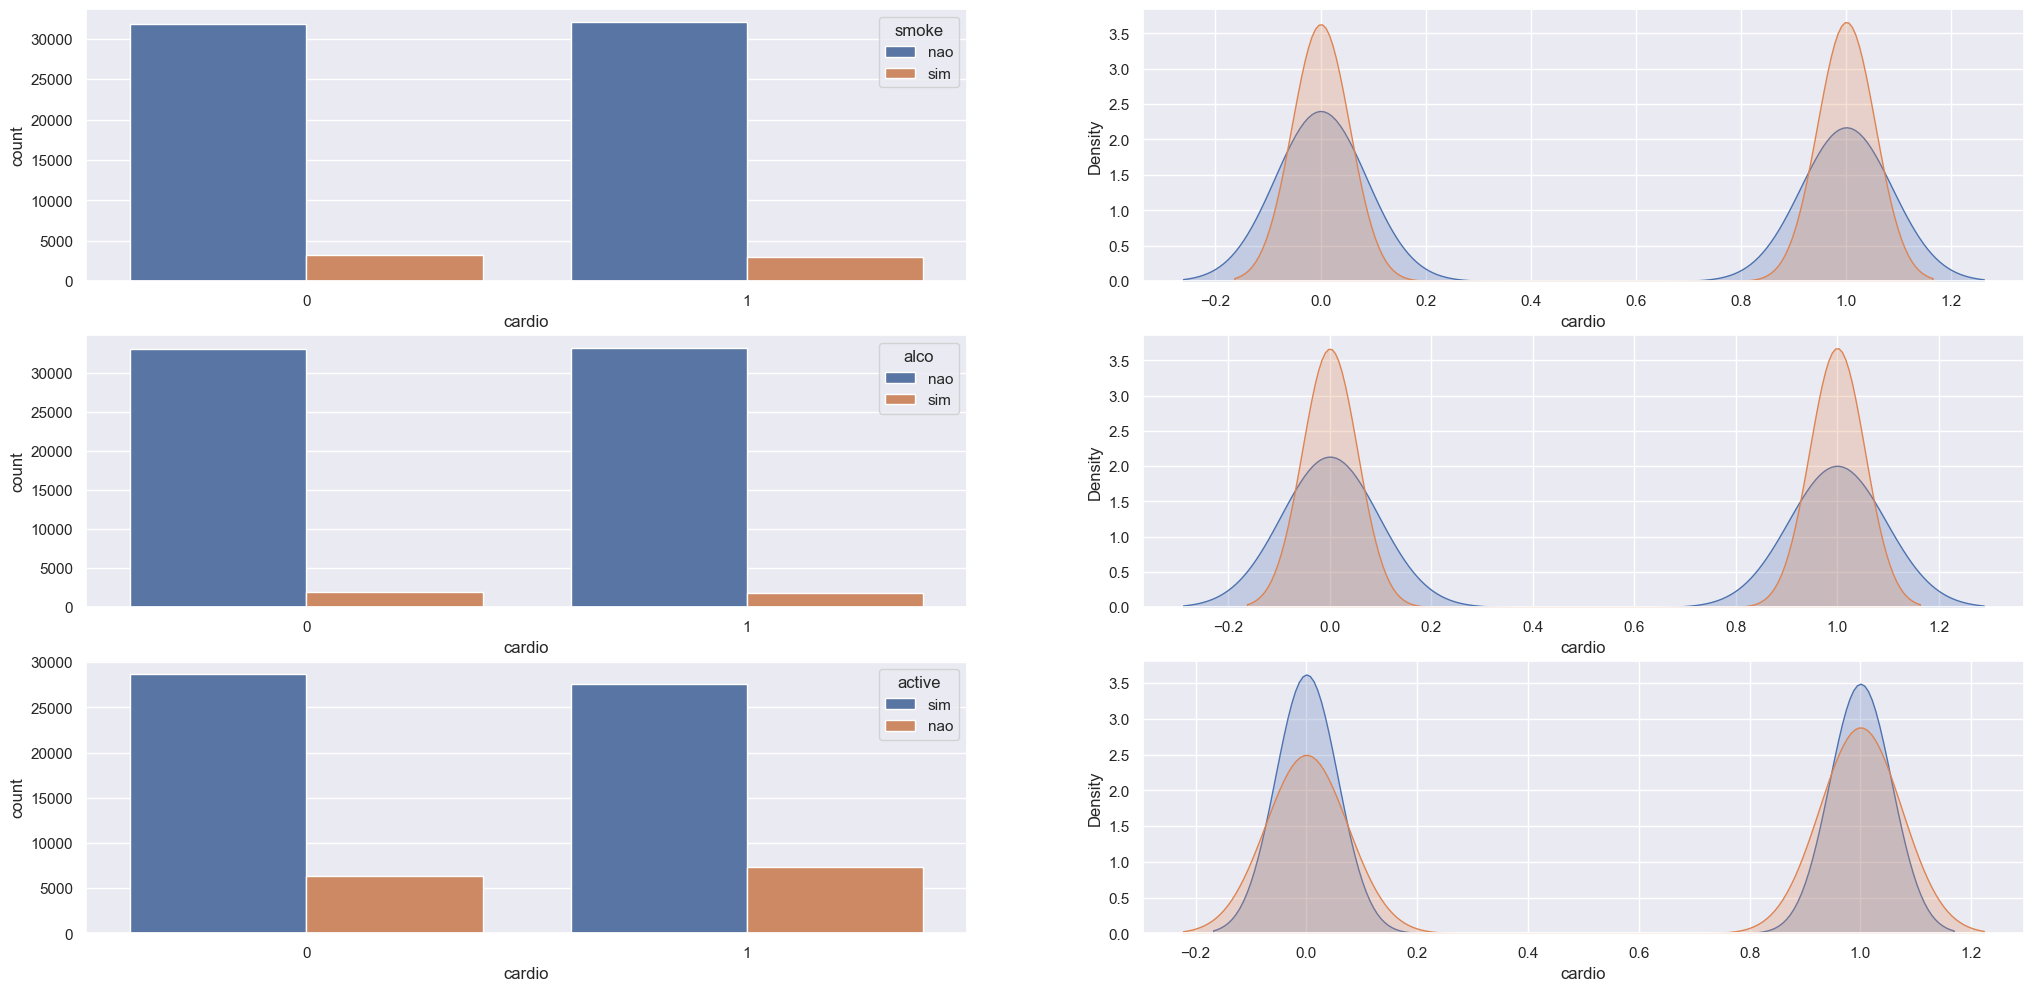

In [23]:
plt.subplot(3, 2, 1)
sns.countplot(
    x='cardio',
    hue=('smoke'),
    data=df_cat,
);

plt.subplot( 3, 2, 2 )
sns.kdeplot( df_cat[df_cat['smoke'] == 'sim']['cardio'], fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['smoke'] == 'nao']['cardio'], fill=True, legend=True );


plt.subplot(3, 2, 3)
sns.countplot(
    x='cardio',
    hue=('alco'),
    data=df_cat,
);

plt.subplot( 3, 2, 4 )
sns.kdeplot( df_cat[df_cat['alco'] == 'sim']['cardio'], fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['alco'] == 'nao']['cardio'], fill=True, legend=True );


plt.subplot(3, 2, 5)
sns.countplot(
    x='cardio',
    hue=('active'),
    data=df_cat,
);

plt.subplot( 3, 2, 6 )
sns.kdeplot( df_cat[df_cat['active'] == 'sim']['cardio'], fill=True, legend=True  ); 
sns.kdeplot( df_cat[df_cat['active'] == 'nao']['cardio'], fill=True, legend=True );


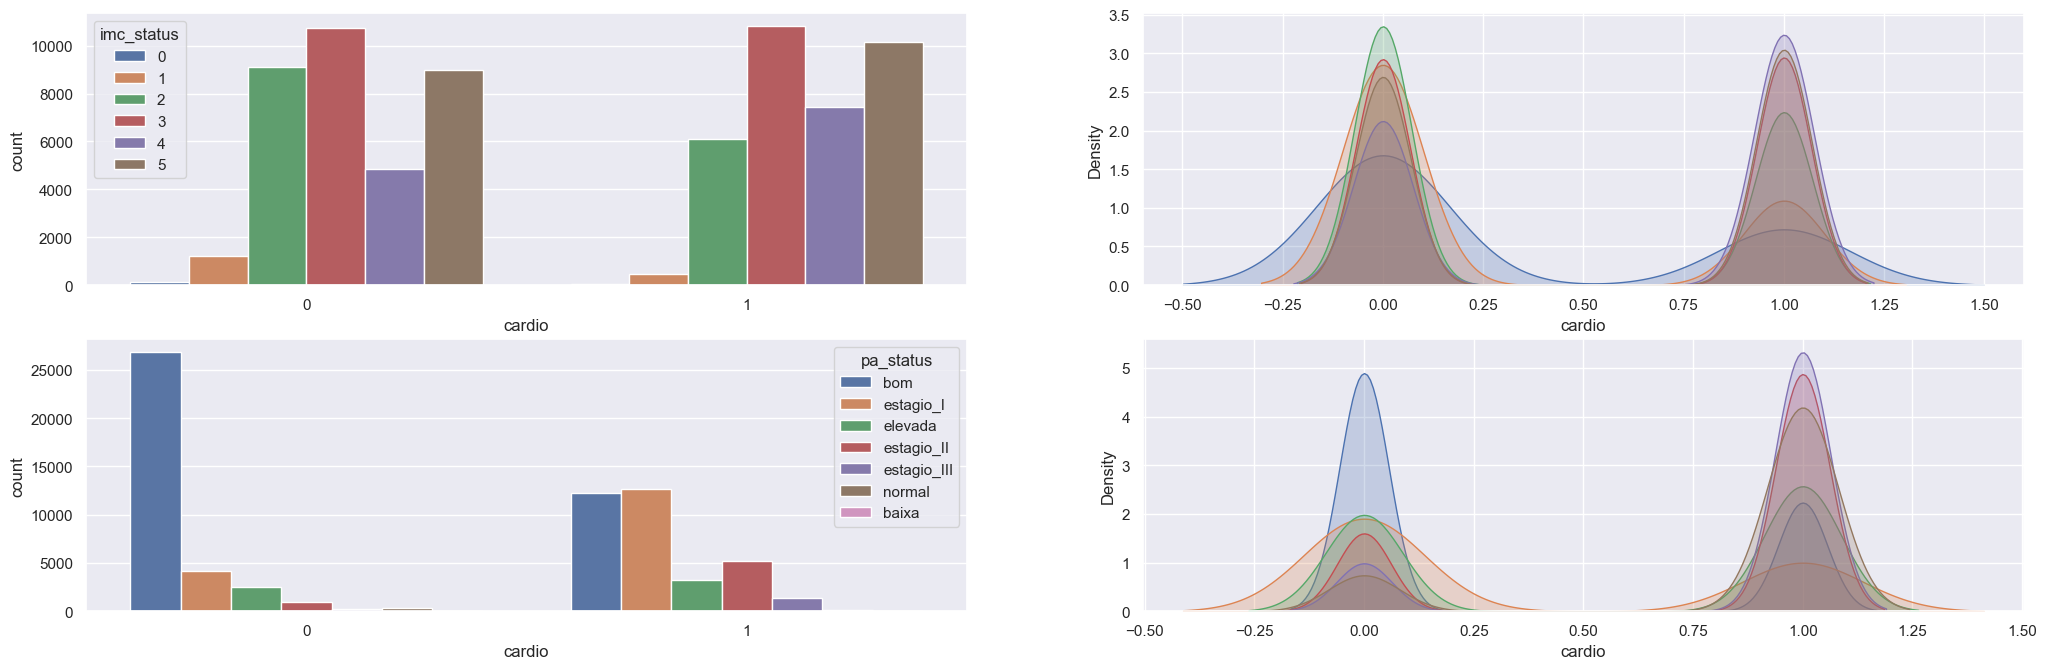

In [24]:
plt.subplot(3, 2, 1)
sns.countplot(
    x='cardio',
    hue=('imc_status'),
    data=df2,
);



plt.subplot( 3, 2, 2 )
sns.kdeplot( df_cat[df_cat['imc_status'] == 'magreza']['cardio'], fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'abaixo']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'normal']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'acima']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'obesidade']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'morbidade']['cardio'], fill=True, legend=True );


plt.subplot(3, 2, 3)
sns.countplot(
    x='cardio',
    hue=('pa_status'),
    data=df_cat,
);


plt.subplot( 3, 2, 4 )
# sns.kdeplot( df_cat[df_cat['pa_status'] == 'baixa']['cardio'], fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'bom']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'normal']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'elevada']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'estagio_I']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'estagio_II']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'estagio_III']['cardio'], fill=True, legend=True );

### Bivariate Analysis

##### Mental Map

#### Hyphoteses List



##### Visão geral das hipóteses: 

1. False  - pouco relevante
2. True   - muito Relevante
3. True   - muito relevante
4. False  - pouco relevante
5. False  - pouco relevante
6. False  - pouco relevante
7. True   - pouco relevante
8. True   - muito relevante
9. True   - muito relevante
10. False - pouco relevante


##### 1. Pessoas do gênero masculino tem mais propensão à desenvolver problemas cardíacos - False/ less relevant

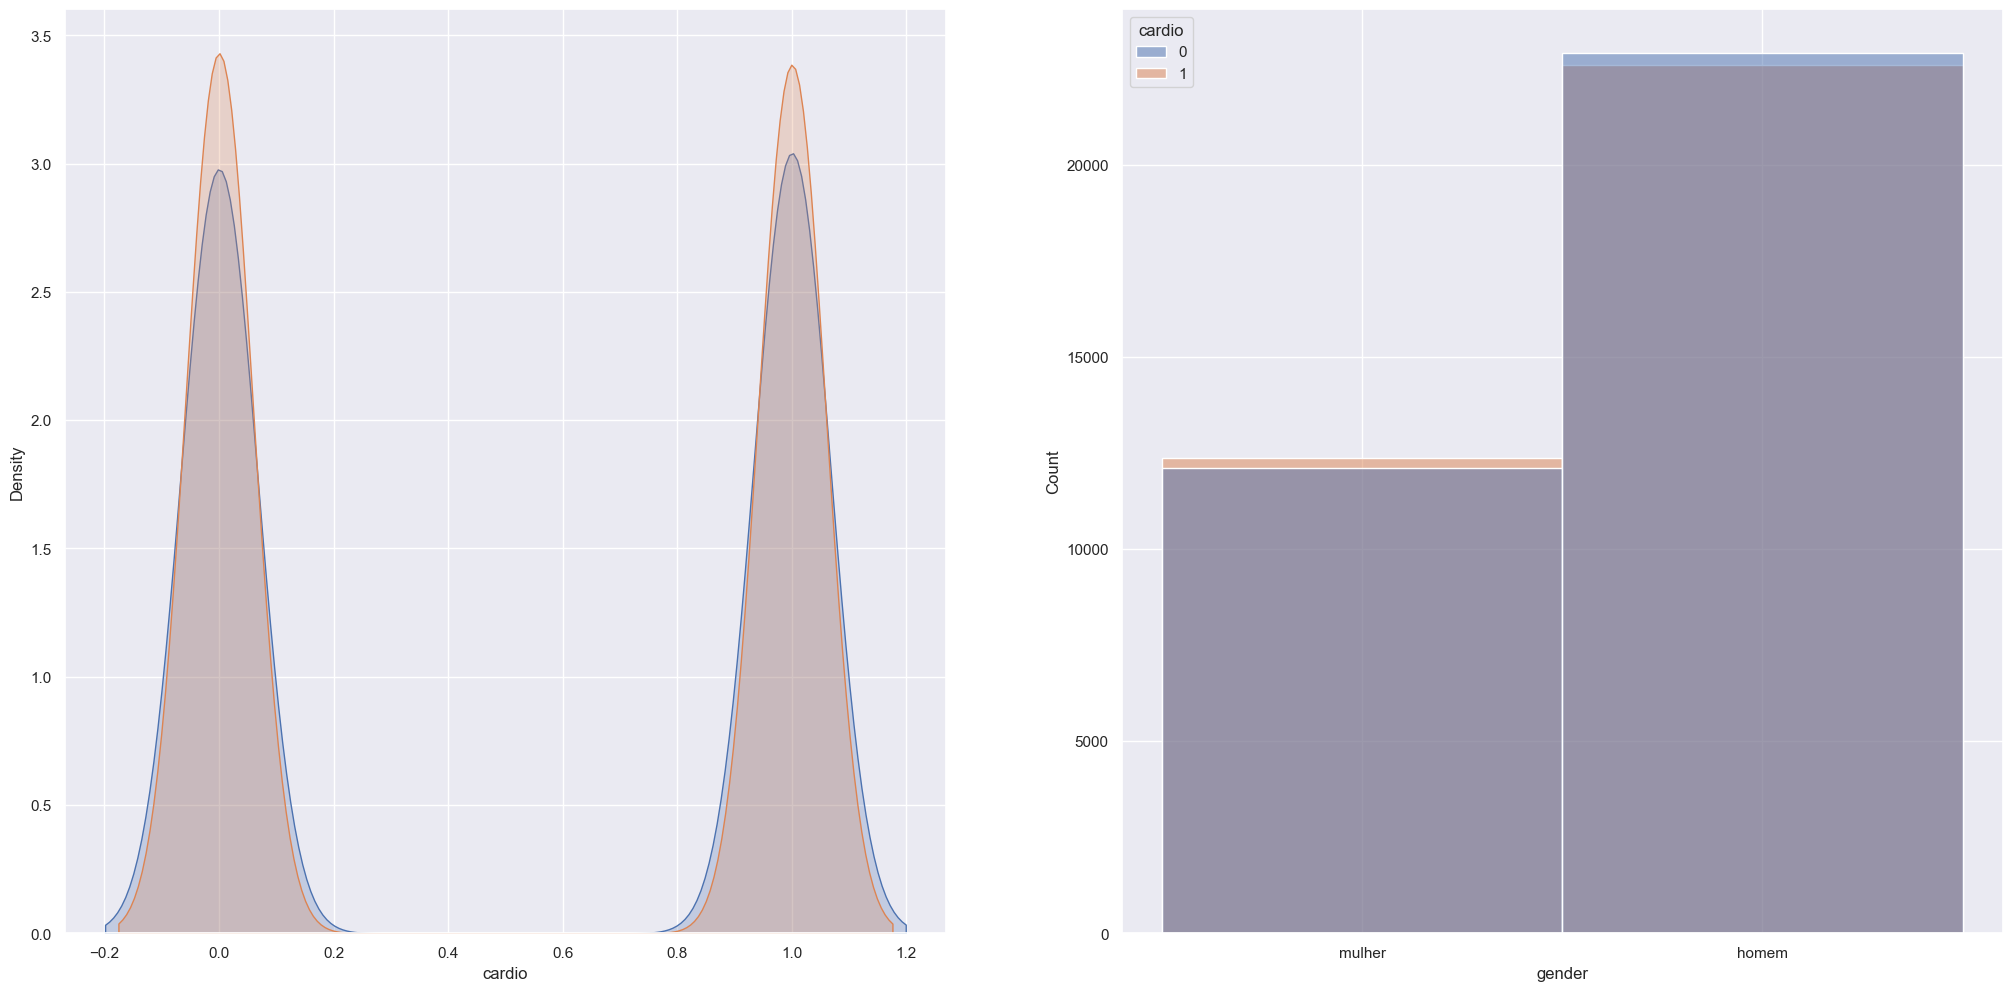

In [25]:
# gender: 1 women, 2 men

plt.subplot( 1, 2, 1 )
sns.kdeplot( df_cat[df_cat['gender'] == 'mulher']['cardio'], fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['gender'] == 'homem']['cardio'], fill=True, legend=True );


plt.subplot( 1, 2, 2 )
sns.histplot(x='gender', hue='cardio', data=df_cat, bins=75);


# False

##### 2. Pessoas com IMC alto tem mais propensão à desenvolver problemas cardíacos - True / Relevant


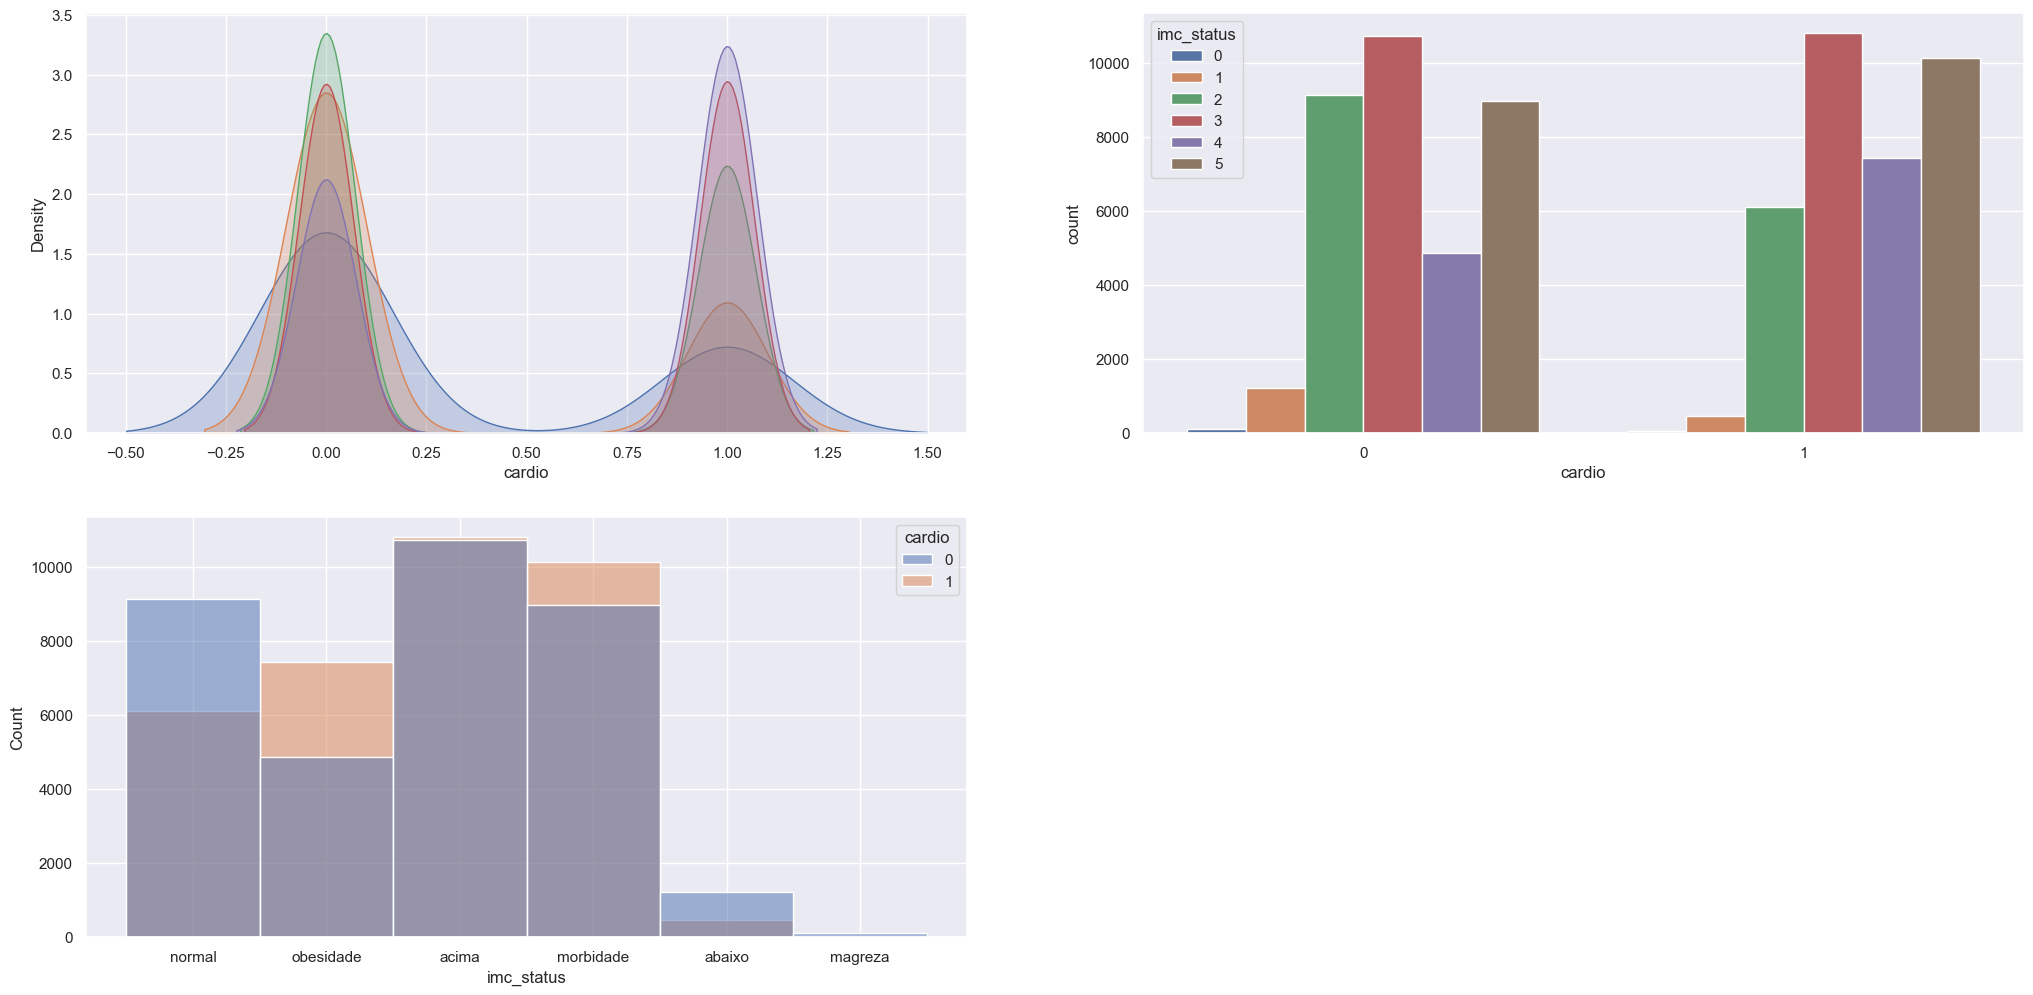

In [39]:
# magreza - < 16.9 - 0
# abaixo - 17 ~ 20 - 1
# normal - 20 ~ 24 - 2
# acima - 25 ~ 29 - 3
# obesidade - 30 ~ 35 - 4
# morbides - > 35 - 5


plt.subplot( 2, 2, 1 )
sns.kdeplot( df_cat[df_cat['imc_status'] == 'magreza']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'abaixo']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'normal']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'acima']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'obesidade']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['imc_status'] == 'morbides']['cardio'], fill=True, legend=True );

plt.subplot( 2, 2, 2 )


sns.countplot(
    x='cardio',
    hue=('imc_status'),
    data=df2,
);

plt.subplot( 2, 2, 3 )
sns.histplot(x='imc_status', hue='cardio', data=df_cat, bins=75);



# True


##### 3. Pessoas idosos tem mais propensão à desenvolver problemas cardíacos - True/Relevant


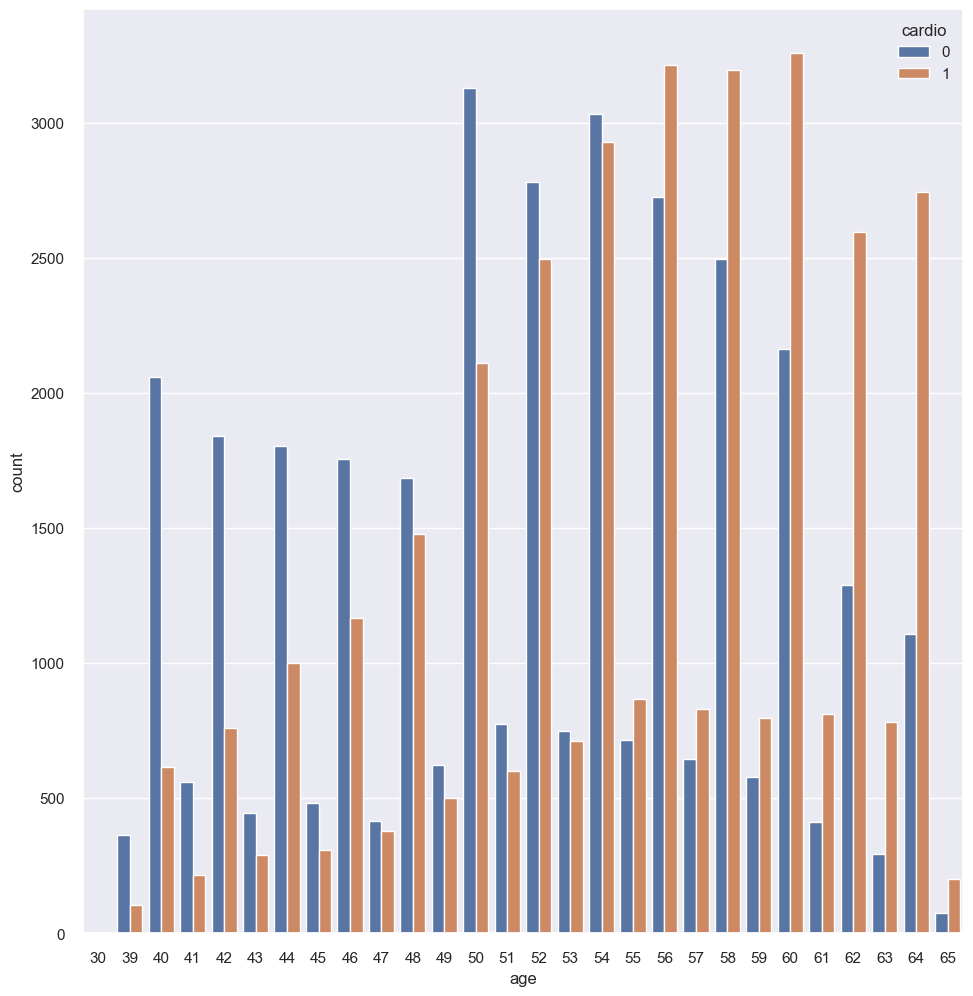

In [ ]:
plt.subplot( 1, 2, 1 )
sns.countplot(x='age', hue='cardio', data=df_cat);

# True

##### 4. Pessoas que NÃO praticam atividades físicas tem mais propensão à desenvolver problemas cardíacos - False


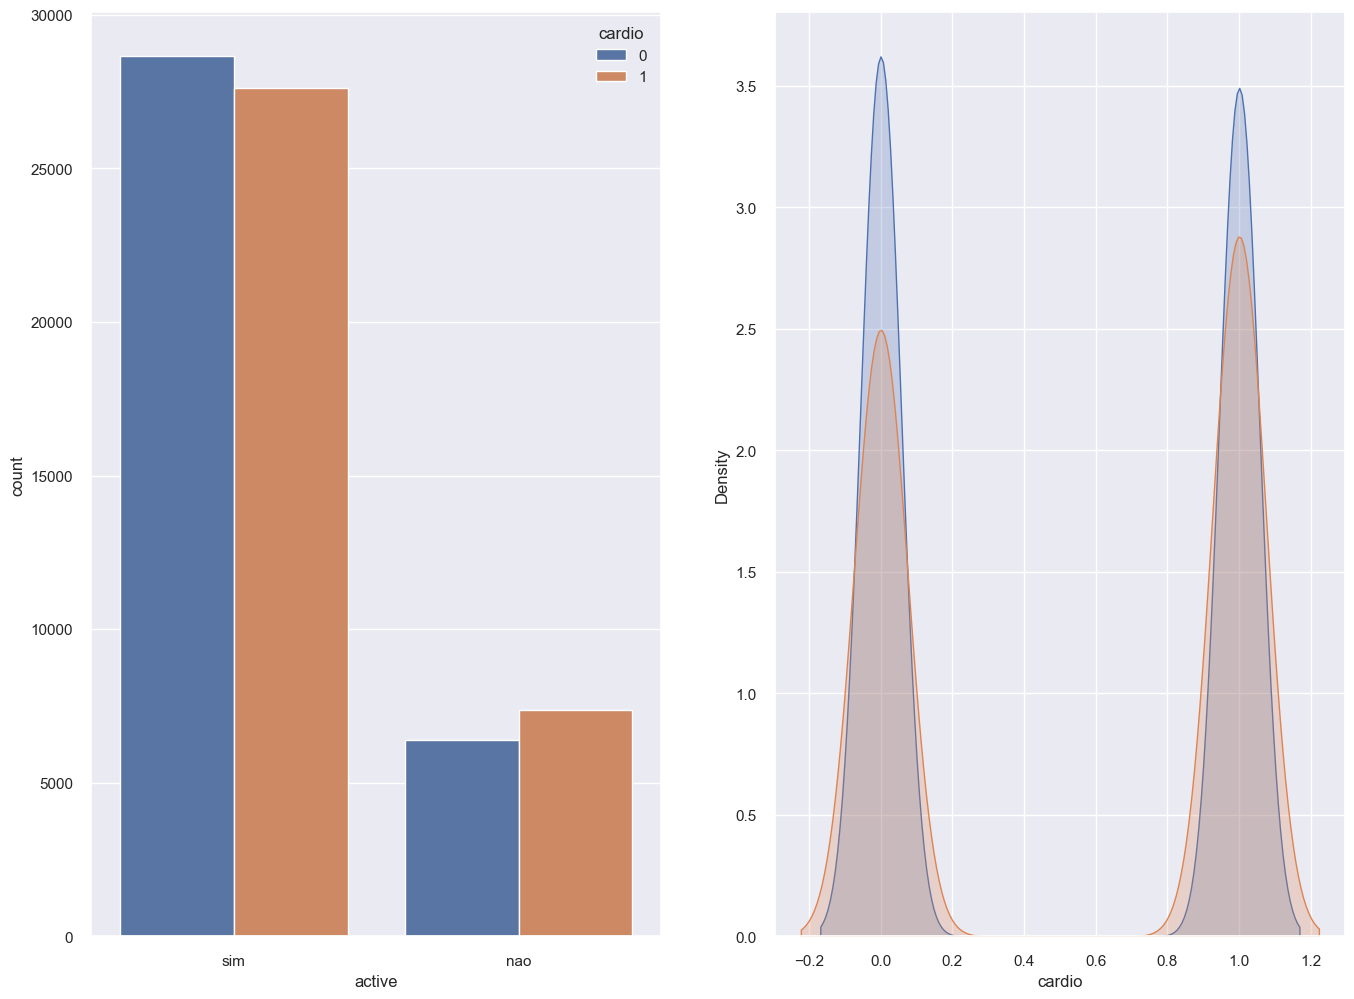

In [ ]:
plt.subplot( 1, 3, 1 )
sns.countplot(x='active', hue='cardio', data=df_cat);

plt.subplot( 1, 3, 2 )
sns.kdeplot( df_cat[df_cat['active'] == 'sim']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['active'] == 'nao']['cardio'], fill=True, legend=True );


# False

##### 5. Fumantes tem mais propensão à desenvolver problemas cardíacos - False


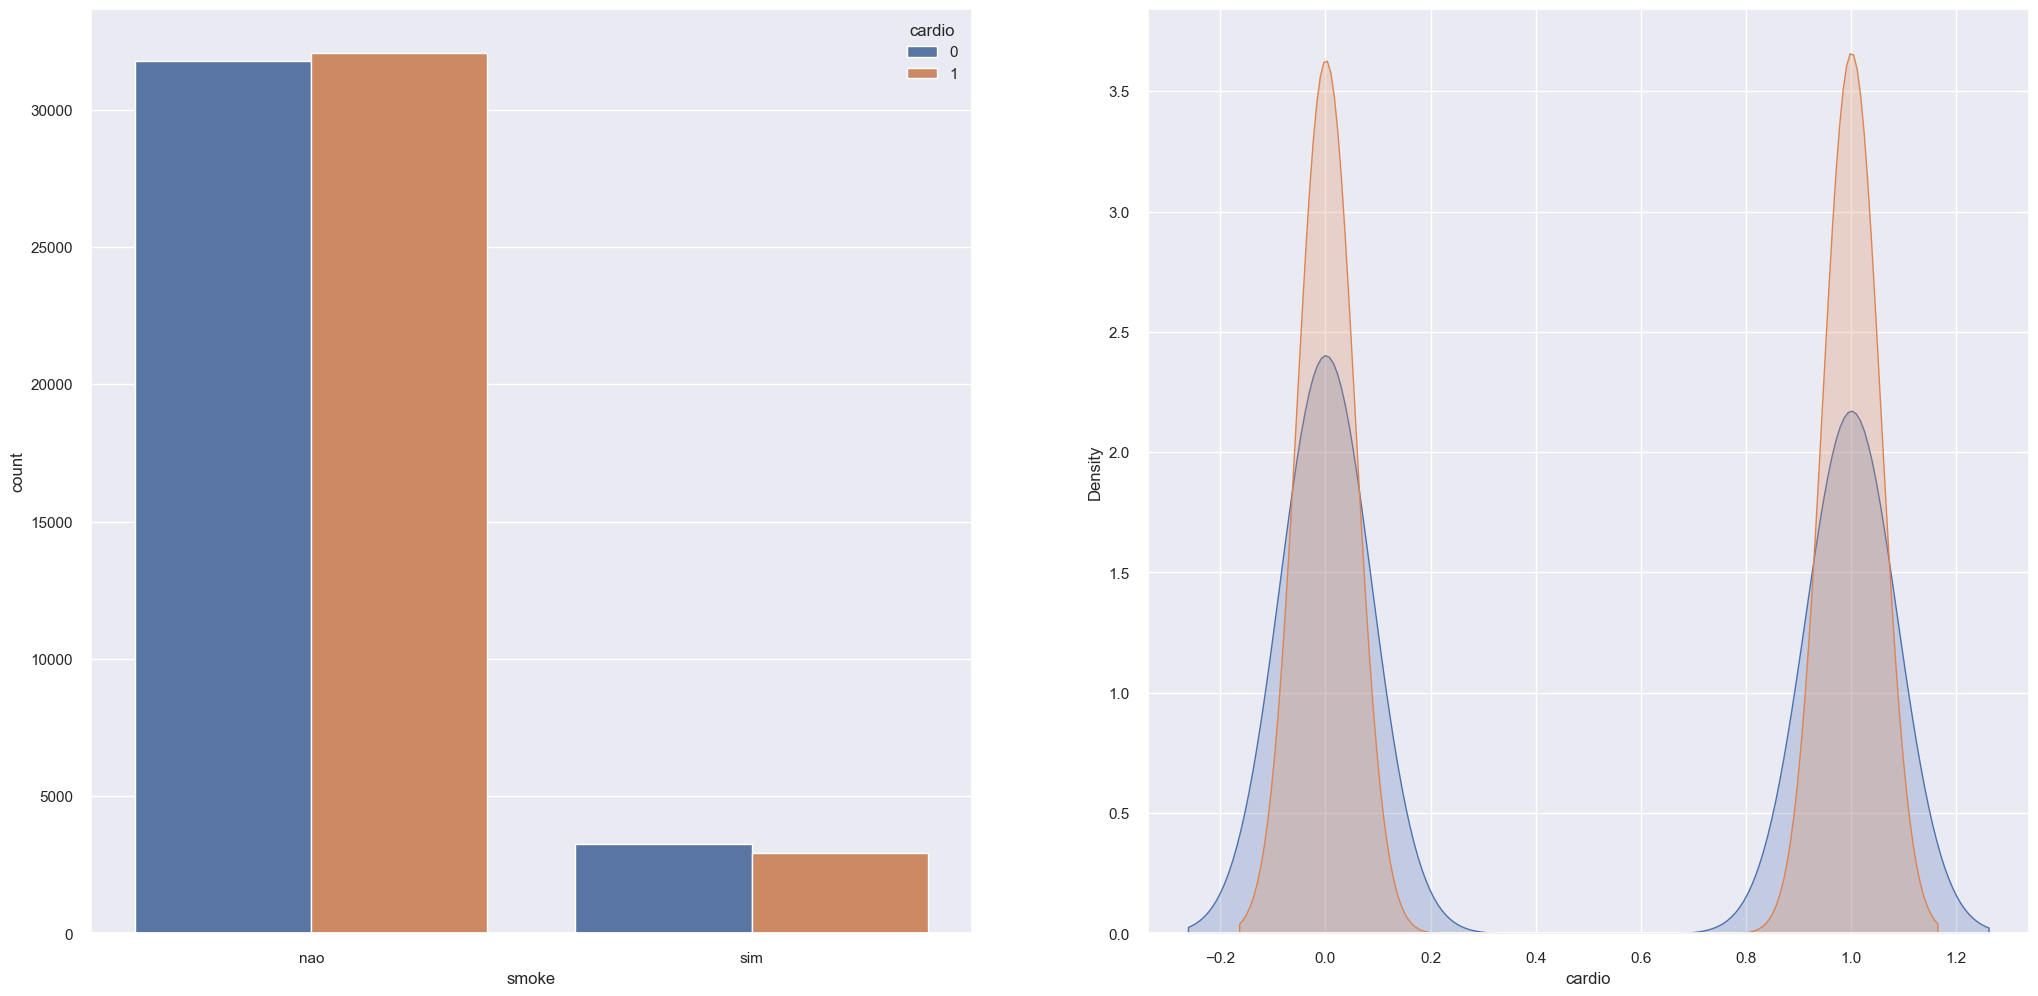

In [ ]:
plt.subplot( 1, 2, 1 )
sns.countplot(x='smoke', hue='cardio', data=df_cat)

plt.subplot( 1, 2, 2 )
sns.kdeplot( df_cat[df_cat['smoke'] == 'sim']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['smoke'] == 'nao']['cardio'], fill=True, legend=True );


# False

##### 6. Pessoas que bebem tem mais propensão à desenvolver problemas cardíacos - False

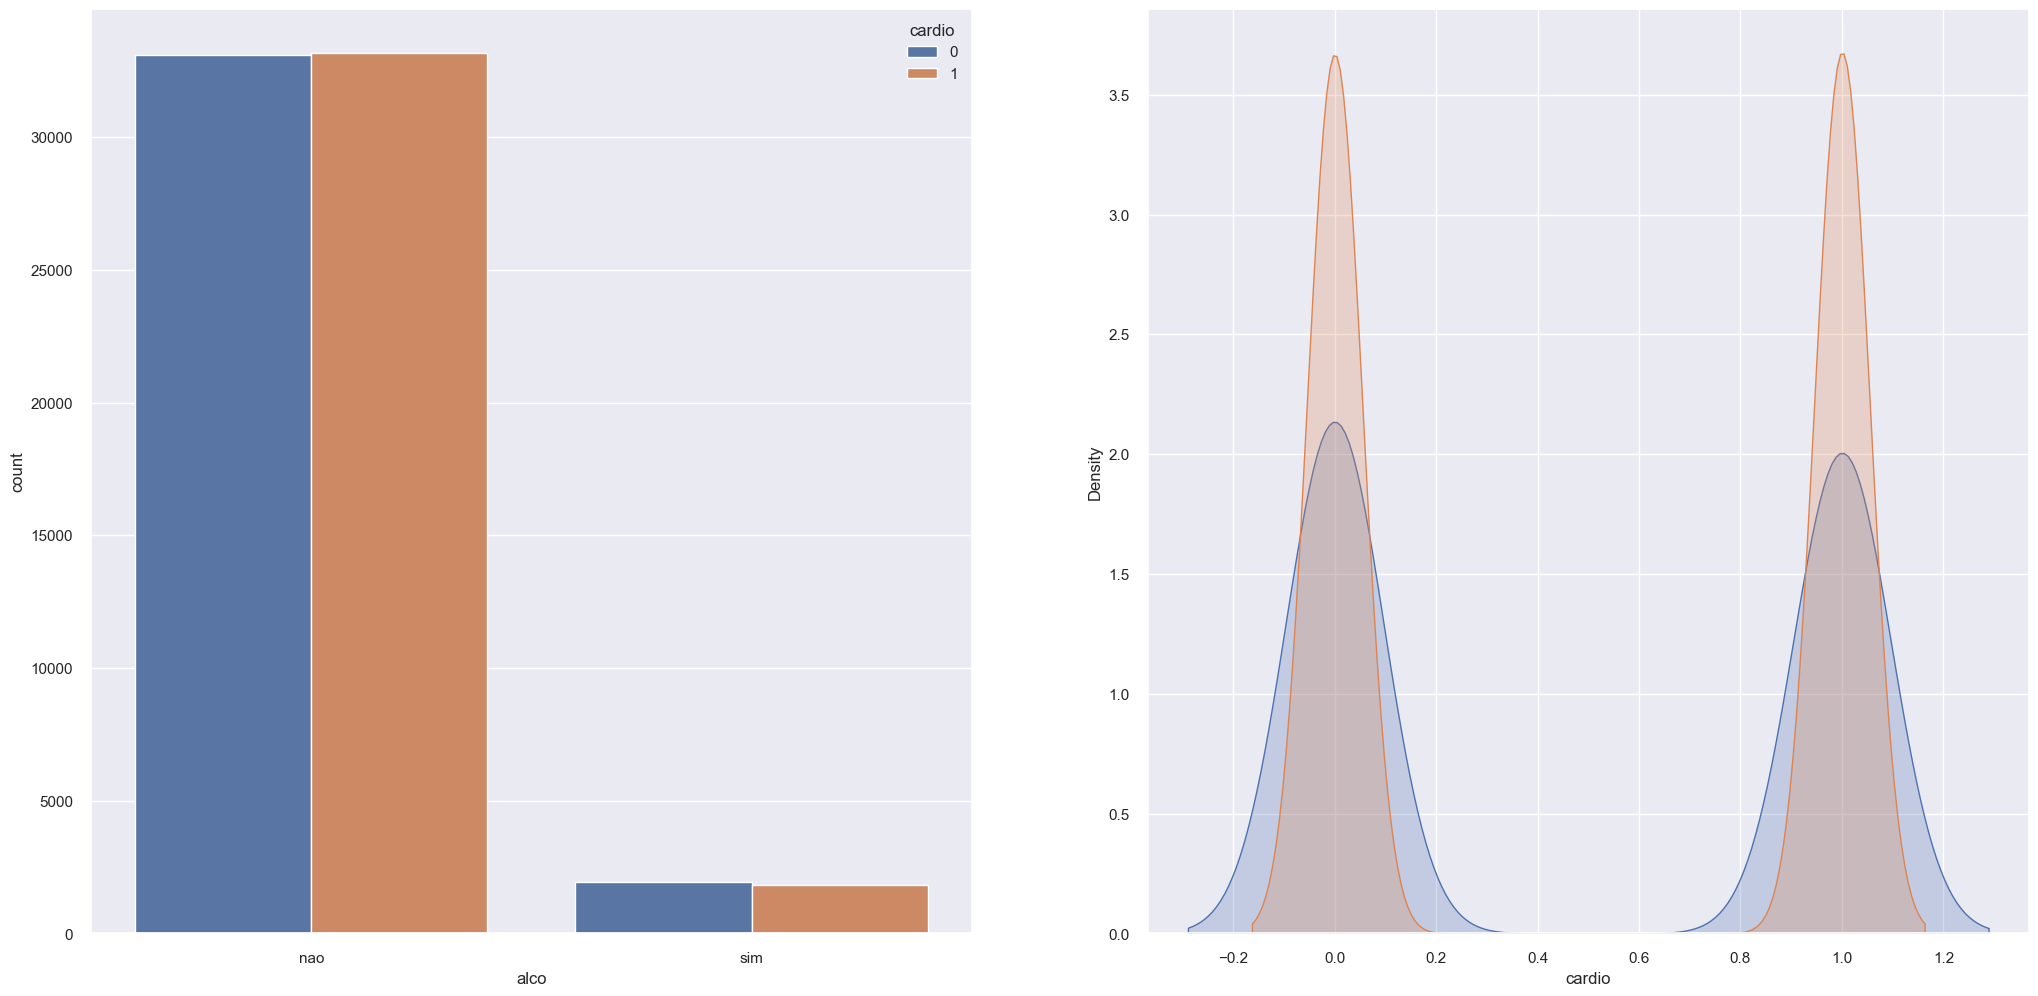

In [ ]:
plt.subplot( 1, 2, 1 )
sns.countplot(x='alco', hue='cardio', data=df_cat)

plt.subplot( 1, 2, 2 )
sns.kdeplot( df_cat[df_cat['alco'] == 'sim']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['alco'] == 'nao']['cardio'], fill=True, legend=True );

# False

##### 7. Pessoas com alta glicemia tem mais propensão à desenvolver problemas cardíacos - True/ not relevante


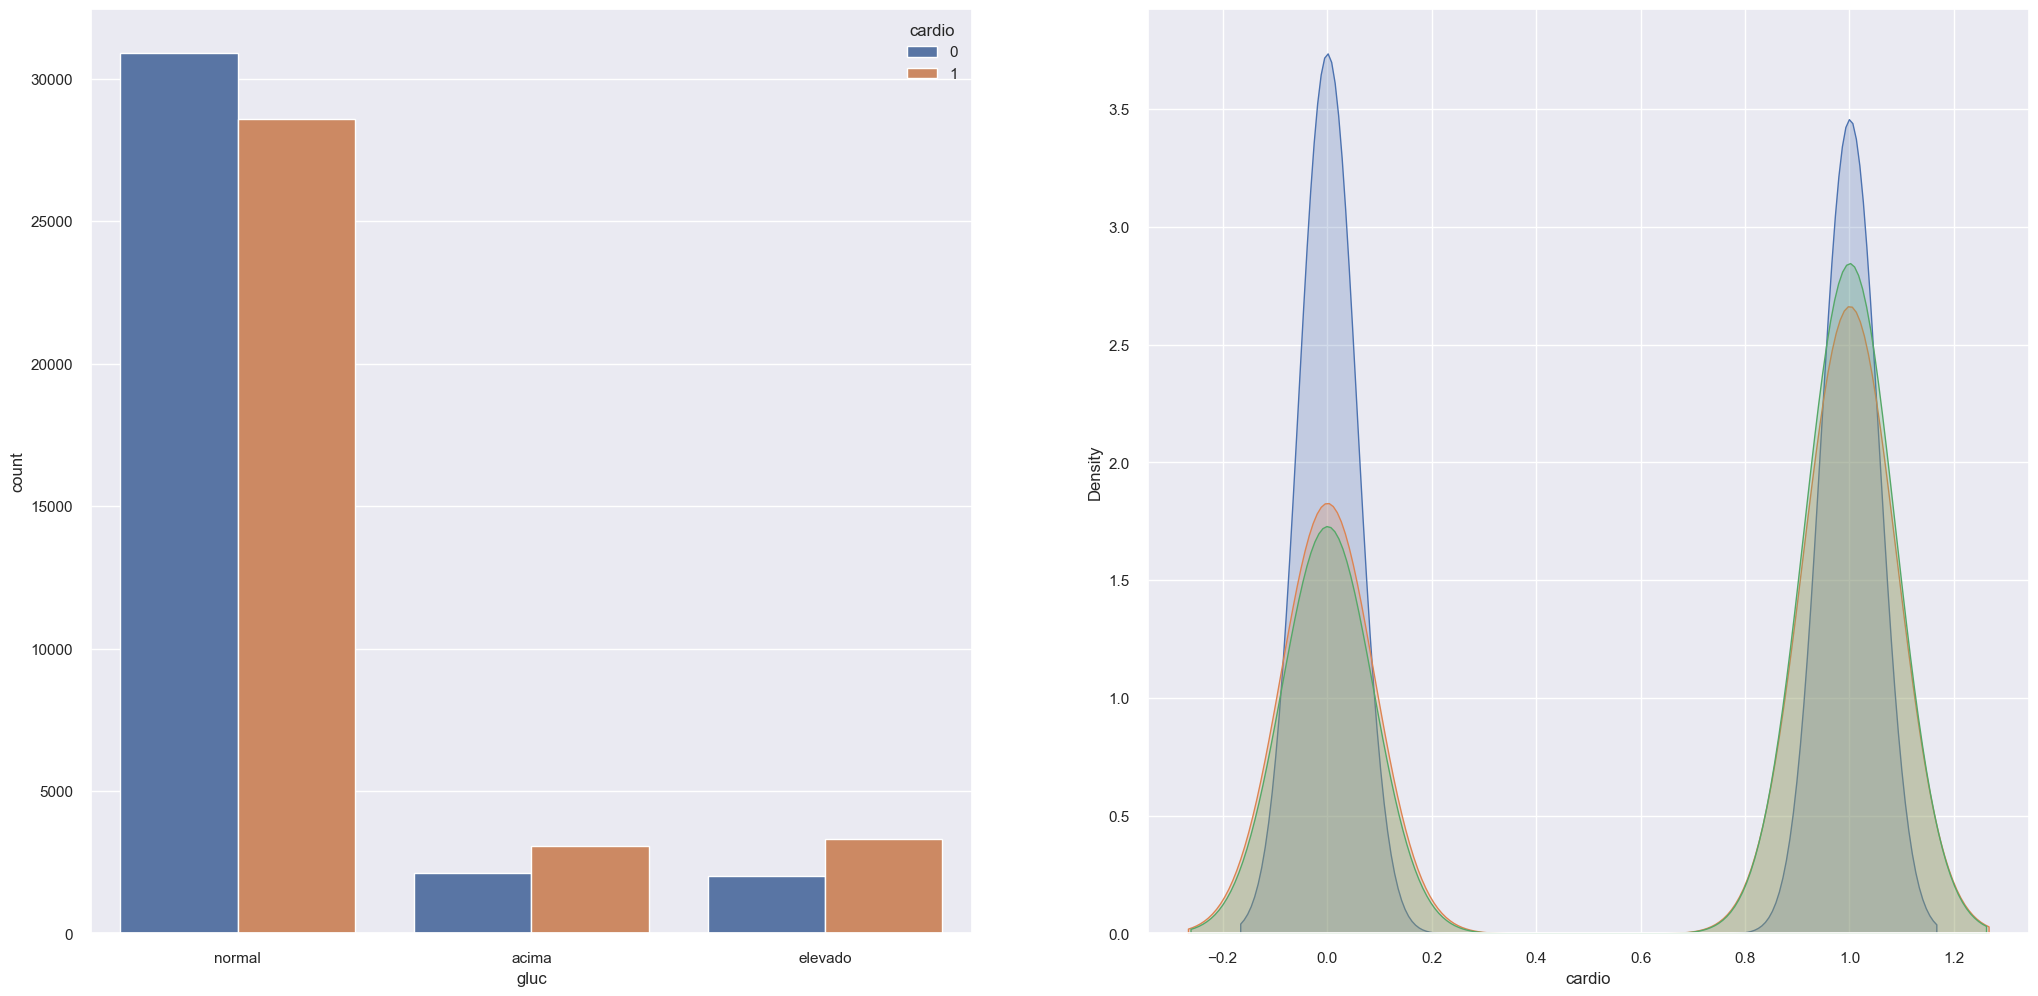

In [ ]:
# soro_map = { 1: 'normal', 2: 'acima', 3: 'elevado'}

plt.subplot( 1, 2, 1 )
sns.countplot(x='gluc', hue='cardio', data=df_cat)

plt.subplot( 1, 2, 2 )
sns.kdeplot( df_cat[df_cat['gluc'] == 'normal']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['gluc'] == 'acima']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['gluc'] == 'elevado']['cardio'], fill=True, legend=True );


# True - But not too relevant

##### 8. Pessoas com alto colesterol tem mais propensão à desenvolver problemas cardíacos - True/relevante


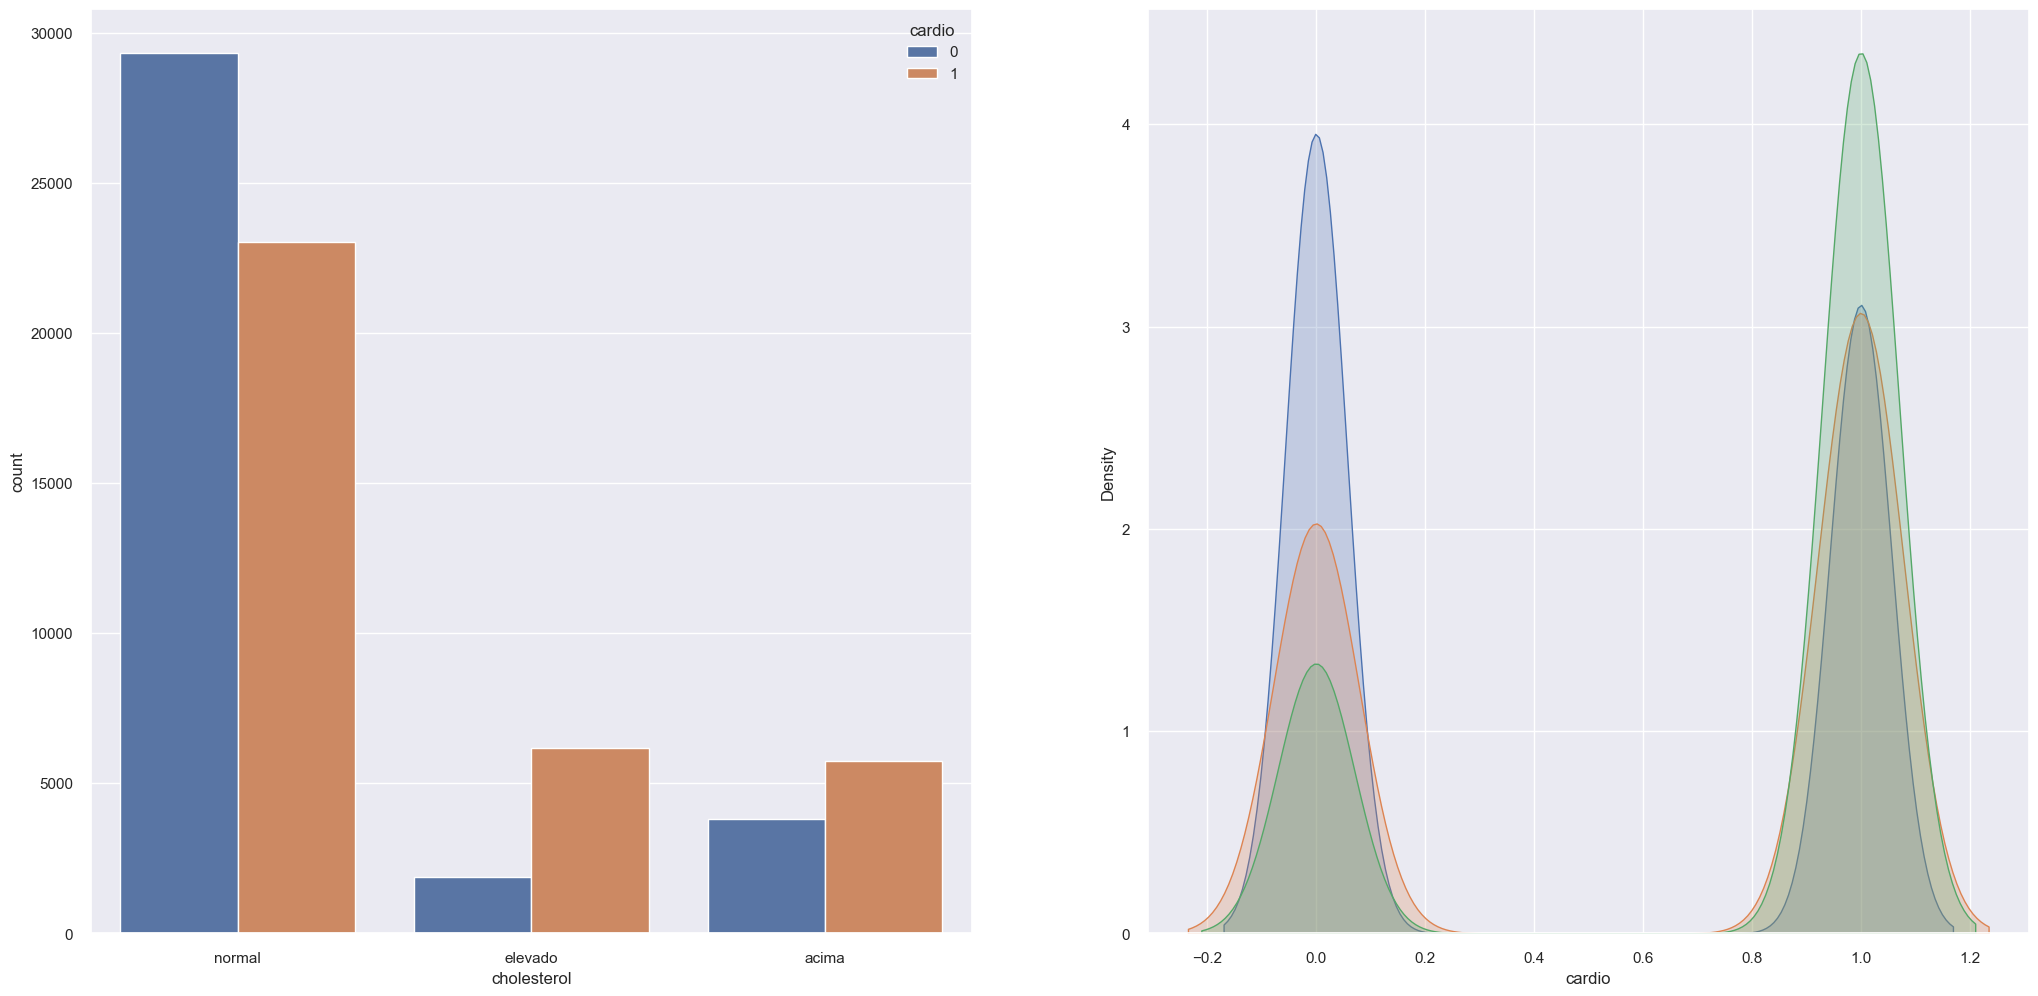

In [ ]:
# soro_map = { 1: 'normal', 2: 'acima', 3: 'elevado'}

plt.subplot( 1, 2, 1 )
sns.countplot(x='cholesterol', hue='cardio', data=df_cat)

plt.subplot( 1, 2, 2 )
sns.kdeplot( df_cat[df_cat['cholesterol'] == 'normal']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['cholesterol'] == 'acima']['cardio'], fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['cholesterol'] == 'elevado']['cardio'], fill=True, legend=True );


# True - Relevant

##### 9. Quanto maior a Pressão Arterial mais propensão à desenvolver problemas cardíacos - True/Relevant


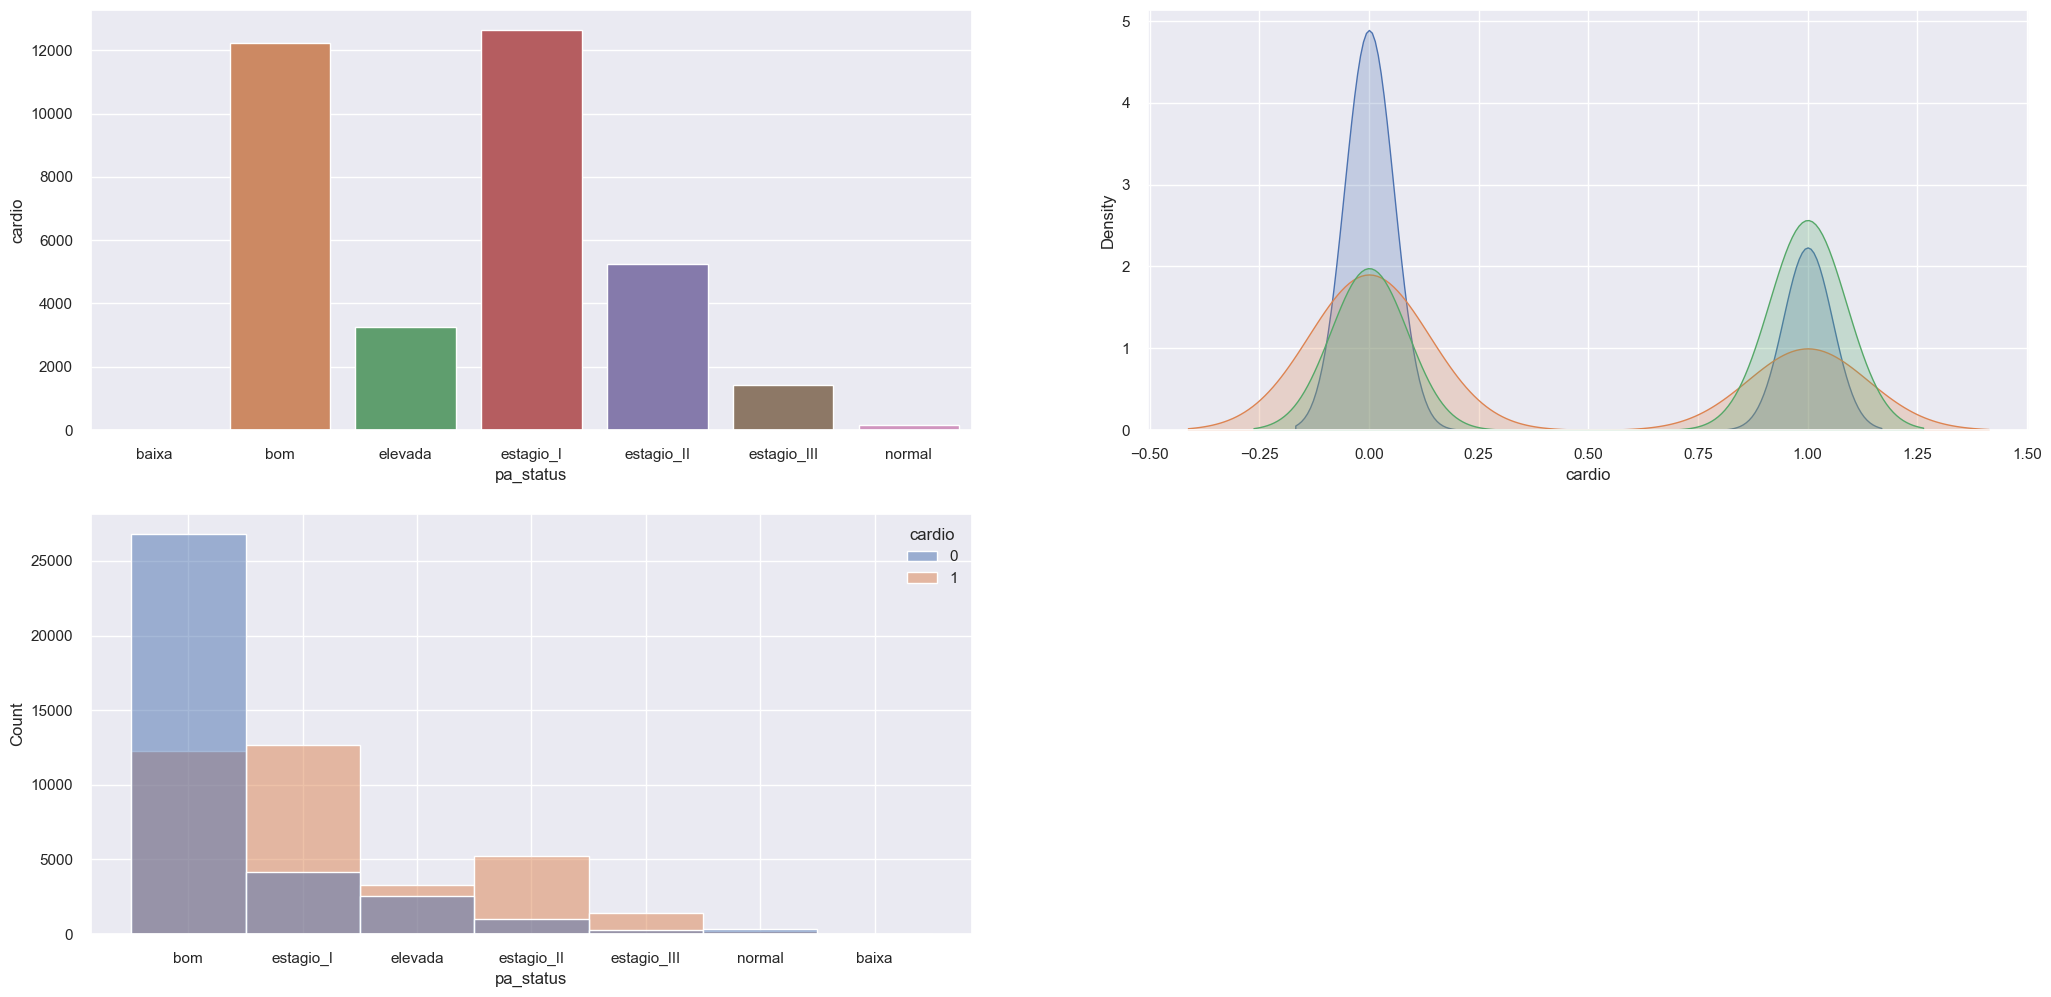

In [ ]:
# Intervalos de PA segundo literatura: 

# baixa:       Hi <80  Lo <40 - 0
# Boa:         Hi <120 Lo <80 - 1
# normal:      Hi <129 Lo <84 - 2
# Elevada:     Hi <139 Lo <89 - 3
# estágio I:   Hi <159 Lo <99 - 4
# Estágio II:  Hi <179 Lo <109 - 5
# Estágio III: Hi >180 Lo >110 - 6

aux1 = df_cat[['pa_status', 'cardio']].groupby( 'pa_status' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x ='pa_status', y='cardio', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.kdeplot( df_cat[df_cat['pa_status'] == 'bom']['cardio'], label = 'bom', fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'normal']['cardio'], label = 'normal', fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'elevada']['cardio'],  label = 'elevada', fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'estágio I']['cardio'],  label = 'estágio I', fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'estágio II']['cardio'], label = 'estágio II', fill=True, legend=True );
sns.kdeplot( df_cat[df_cat['pa_status'] == 'estágio III']['cardio'], label = 'estágio III', fill=True, legend=True );


plt.subplot( 2, 2, 3 )
# sns.kdeplot( df_cat[df_cat['pa_status'] == 'baixa']['cardio'], fill=True, legend=True );

sns.histplot(x='pa_status', hue='cardio', data=df_cat, bins=75);

# True - relevante

##### 10. Altura não é relevante para o desenvolvimento de cardiopatias - False/less relevante

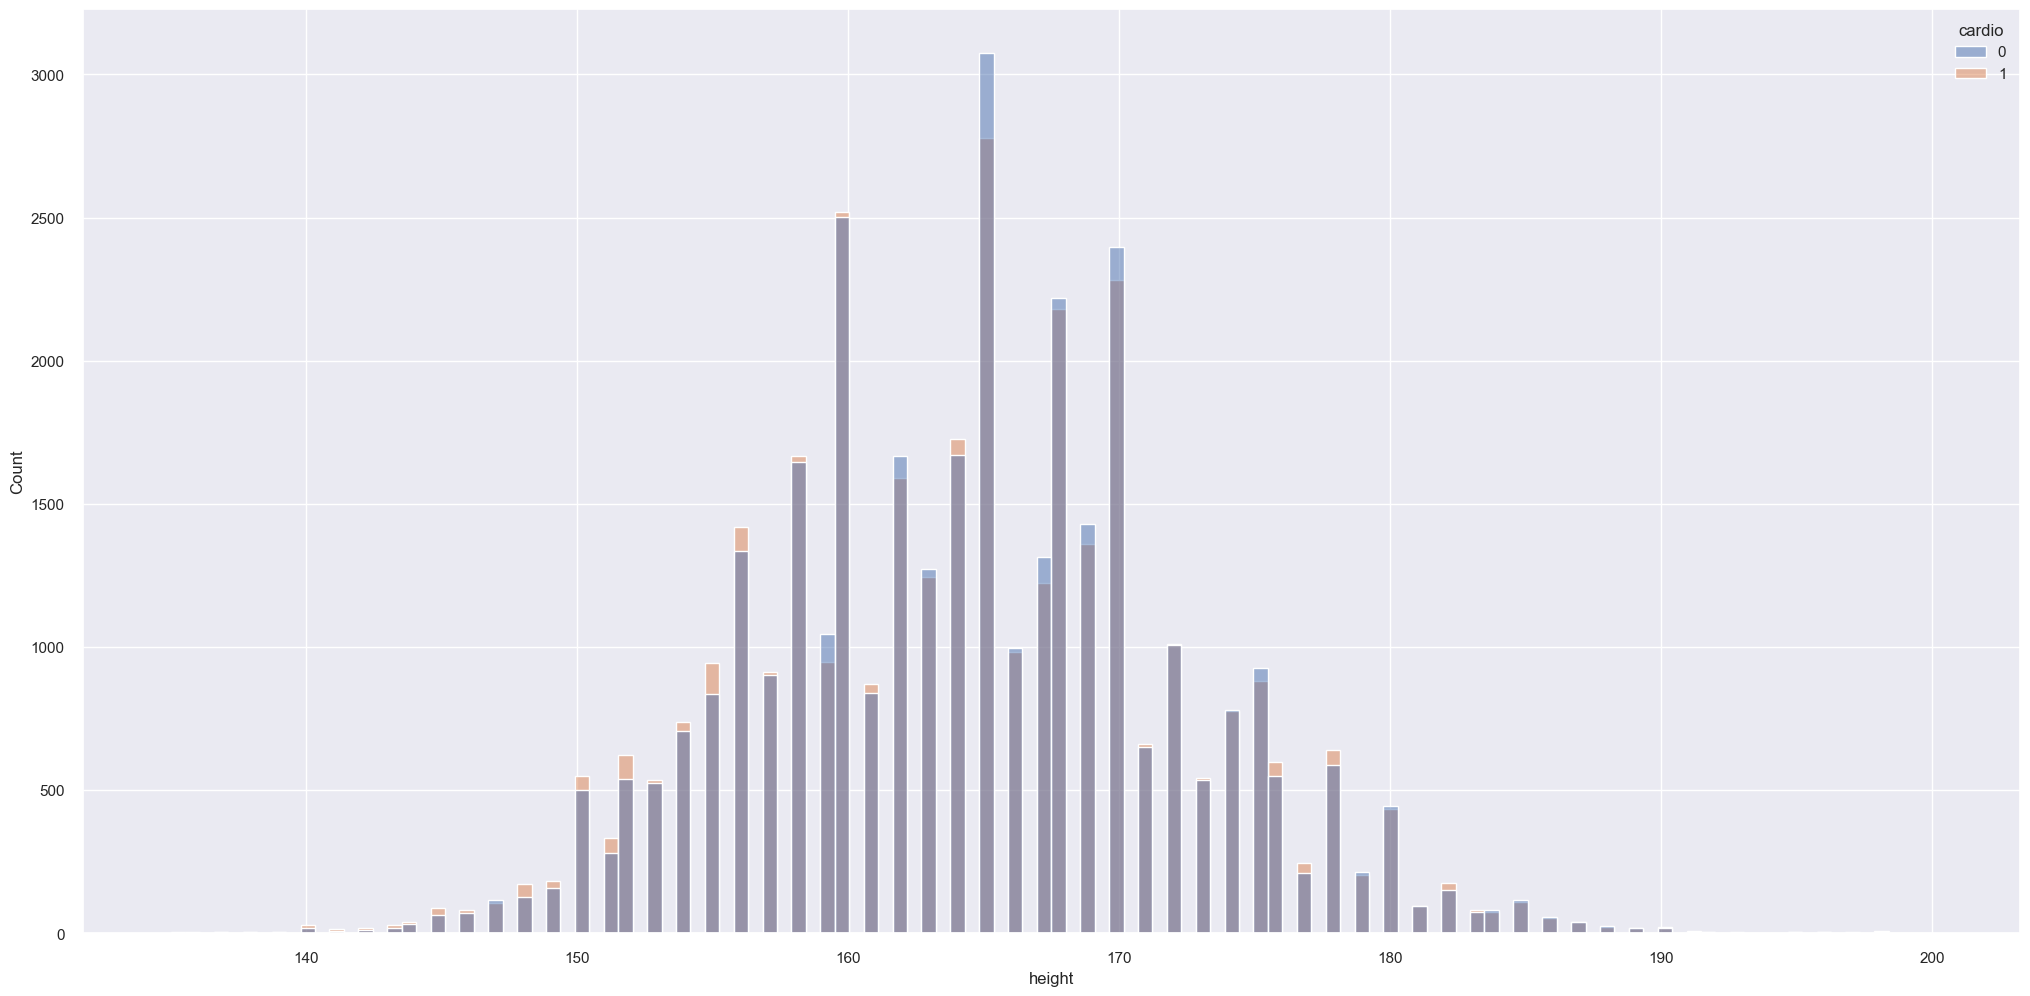

In [ ]:
filtro = df_cat[(df_cat['height'] >= 135) & (df_cat['height'] <= 200)]
sns.histplot(x='height', hue='cardio', data=filtro);

# False - pouco relevante 

### Multivariate Analysis

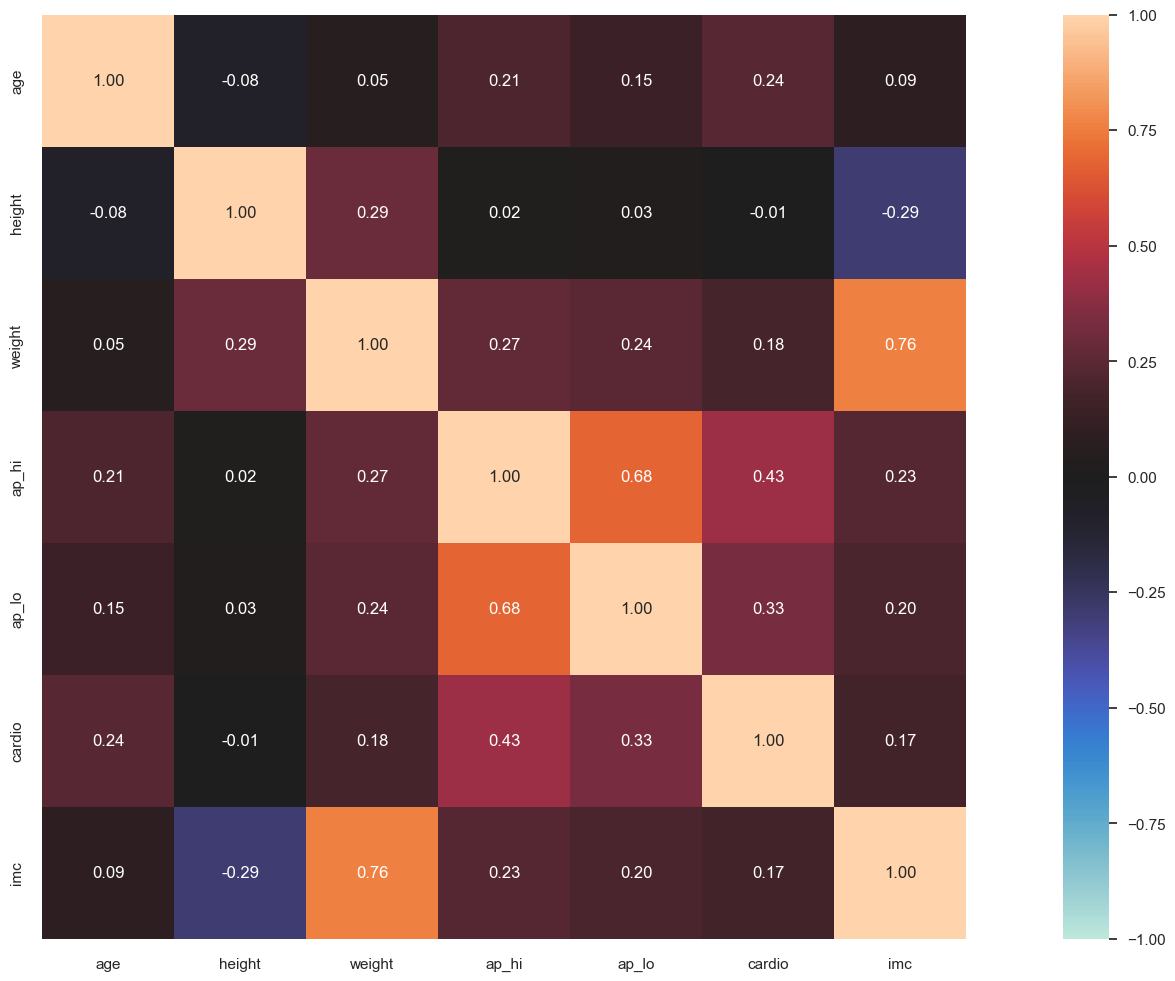

In [ ]:
# Variáveis numéricas:

nominal.associations(num_attributes.drop('id',axis = 1));

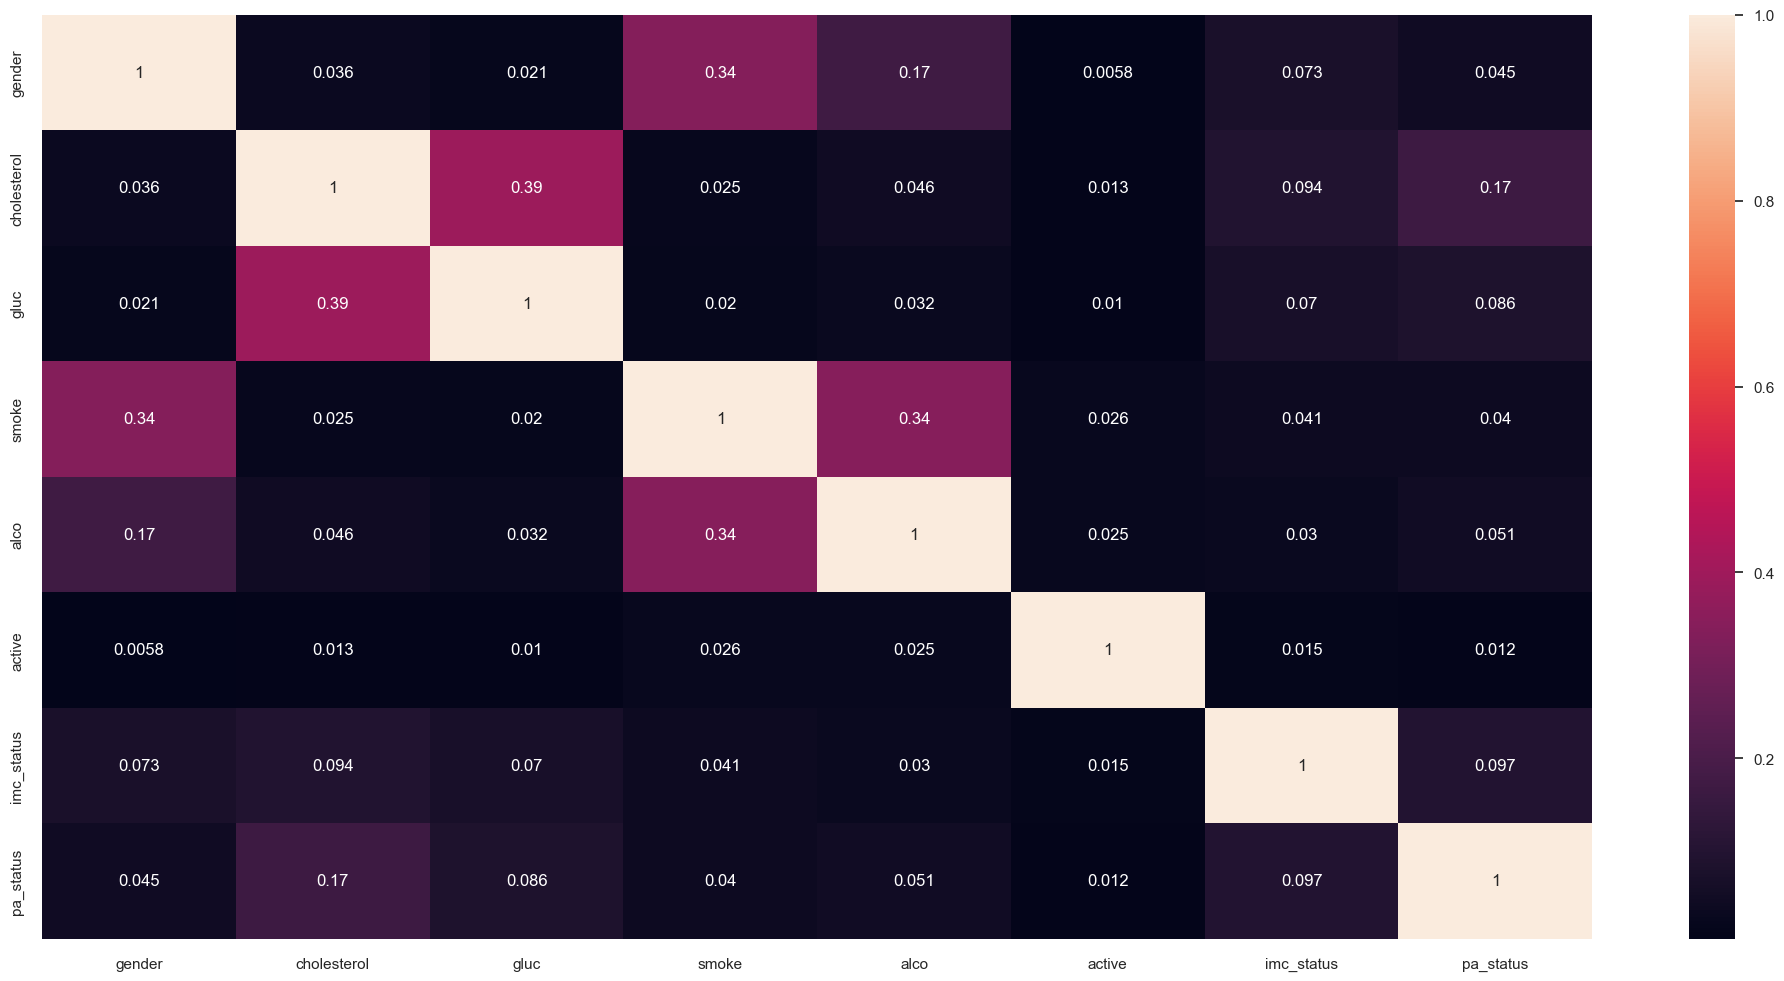

In [ ]:
# Variáveis categóricas

a = df_cat.select_dtypes( include='object' )

a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['cholesterol'] )
a3 = cramer_v( a['gender'], a['gluc'] )
a4 = cramer_v( a['gender'], a['smoke'] )
a5 = cramer_v( a['gender'], a['alco'] )
a6 = cramer_v( a['gender'], a['active'] )
a7 = cramer_v( a['gender'], a['imc_status'] )
a8 = cramer_v( a['gender'], a['pa_status'] )

a9 = cramer_v( a['cholesterol'], a['gender'] )
a10 = cramer_v( a['cholesterol'], a['cholesterol'] )
a11 = cramer_v( a['cholesterol'], a['gluc'] )
a12 = cramer_v( a['cholesterol'], a['smoke'] )
a13 = cramer_v( a['cholesterol'], a['alco'] )
a14 = cramer_v( a['cholesterol'], a['active'] )
a15 = cramer_v( a['cholesterol'], a['imc_status'] )
a16 = cramer_v( a['cholesterol'], a['pa_status'] )

a17 = cramer_v( a['gluc'], a['gender'] )
a18 = cramer_v( a['gluc'], a['cholesterol'] )
a19 = cramer_v( a['gluc'], a['gluc'] )
a20 = cramer_v( a['gluc'], a['smoke'] )
a21 = cramer_v( a['gluc'], a['alco'] )
a22 = cramer_v( a['gluc'], a['active'] )
a23 = cramer_v( a['gluc'], a['imc_status'] )
a24 = cramer_v( a['gluc'], a['pa_status'] )

a25 = cramer_v( a['smoke'], a['gender'] )
a26 = cramer_v( a['smoke'], a['cholesterol'] )
a27 = cramer_v( a['smoke'], a['gluc'] )
a28 = cramer_v( a['smoke'], a['smoke'] )
a29 = cramer_v( a['smoke'], a['alco'] )
a30 = cramer_v( a['smoke'], a['active'] )
a31 = cramer_v( a['smoke'], a['imc_status'] )
a32 = cramer_v( a['smoke'], a['pa_status'] )

a33 = cramer_v( a['alco'], a['gender'] )
a34 = cramer_v( a['alco'], a['cholesterol'] )
a35 = cramer_v( a['alco'], a['gluc'] )
a36 = cramer_v( a['alco'], a['smoke'] )
a37 = cramer_v( a['alco'], a['alco'] )
a38 = cramer_v( a['alco'], a['active'] )
a39 = cramer_v( a['alco'], a['imc_status'] )
a40 = cramer_v( a['alco'], a['pa_status'] )

a41 = cramer_v( a['active'], a['gender'] )
a42 = cramer_v( a['active'], a['cholesterol'] )
a43 = cramer_v( a['active'], a['gluc'] )
a44 = cramer_v( a['active'], a['smoke'] )
a45 = cramer_v( a['active'], a['alco'] )
a46 = cramer_v( a['active'], a['active'] )
a47 = cramer_v( a['active'], a['imc_status'] )
a48 = cramer_v( a['active'], a['pa_status'] )

a49 = cramer_v( a['imc_status'], a['gender'] )
a50 = cramer_v( a['imc_status'], a['cholesterol'] )
a51 = cramer_v( a['imc_status'], a['gluc'] )
a52 = cramer_v( a['imc_status'], a['smoke'] )
a53 = cramer_v( a['imc_status'], a['alco'] )
a54 = cramer_v( a['imc_status'], a['active'] )
a55 = cramer_v( a['imc_status'], a['imc_status'] )
a56 = cramer_v( a['imc_status'], a['pa_status'] )

a57 = cramer_v( a['pa_status'], a['gender'] )
a58 = cramer_v( a['pa_status'], a['cholesterol'] )
a59 = cramer_v( a['pa_status'], a['gluc'] )
a60 = cramer_v( a['pa_status'], a['smoke'] )
a61 = cramer_v( a['pa_status'], a['alco'] )
a62 = cramer_v( a['pa_status'], a['active'] )
a63 = cramer_v( a['pa_status'], a['imc_status'] )
a64 = cramer_v( a['pa_status'], a['pa_status'] )


# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3, a4, a5, a6, a7, a8], 
               'cholesterol': [a9, a10, a11, a12, a13, a14, a15, a16],
               'gluc': [a17, a18, a19, a20, a21, a22, a23, a24],
               'smoke': [a25, a26, a27, a28, a29, a30, a31, a32],
               'alco': [a33, a34, a35, a36, a37, a38, a39, a40],
               'active': [a41, a42, a43, a44, a45, a46, a47, a48],
               'imc_status': [a49, a50, a51, a52, a53, a54, a55, a56],
               'pa_status': [a57, a58, a59, a60, a61, a62, a63, a64]  })


d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

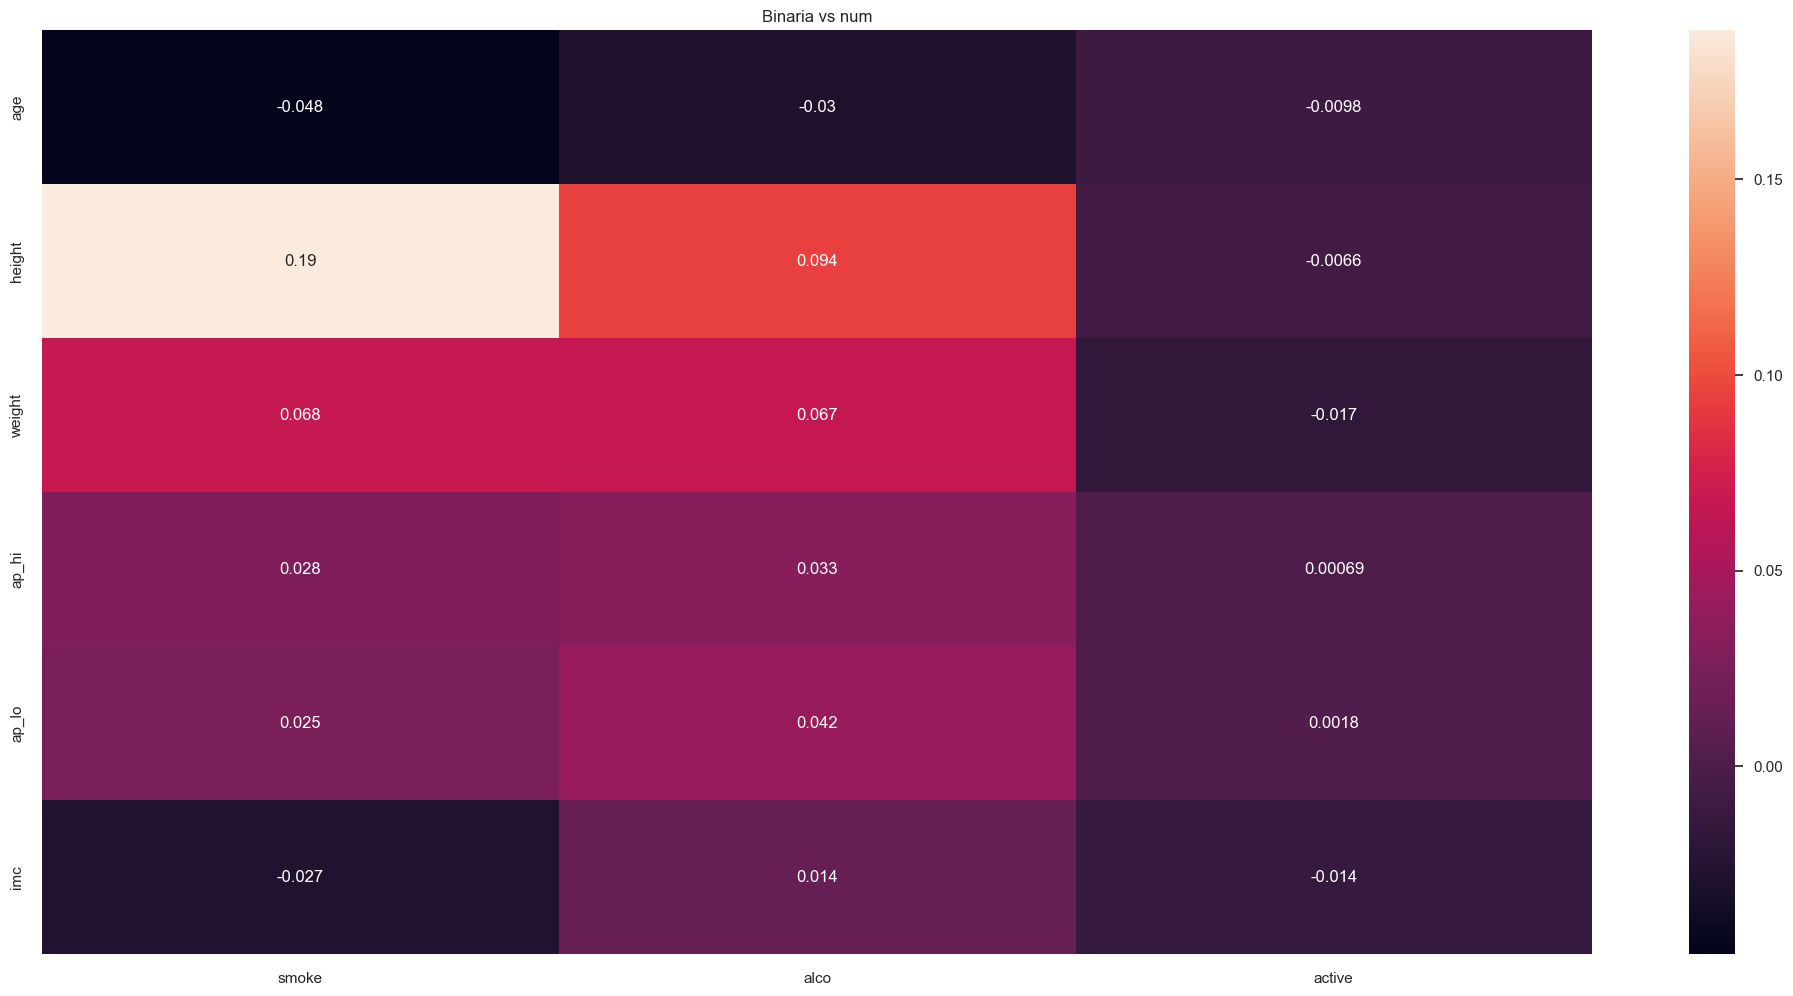

In [ ]:
# Comparação das variáveis binárias com as numéricas.

binarias = df3[['smoke', 'alco', 'active']]
numericas = df_cat[['age','height','weight','ap_hi','ap_lo', 'imc']]

a1 = pointbiserialr(binarias['smoke'], numericas['age'])[0]
a2 = pointbiserialr(binarias['smoke'], numericas['height'])[0]
a3 = pointbiserialr(binarias['smoke'], numericas['weight'])[0]
a4 = pointbiserialr(binarias['smoke'], numericas['ap_hi'])[0]
a5 = pointbiserialr(binarias['smoke'], numericas['ap_lo'])[0]
a6 = pointbiserialr(binarias['smoke'], numericas['imc'])[0]


a7 = pointbiserialr(binarias['alco'], numericas['age'])[0]
a8 = pointbiserialr(binarias['alco'], numericas['height'])[0]
a9 = pointbiserialr(binarias['alco'], numericas['weight'])[0]
a10 = pointbiserialr(binarias['alco'], numericas['ap_hi'])[0]
a11 = pointbiserialr(binarias['alco'], numericas['ap_lo'])[0]
a12 = pointbiserialr(binarias['alco'], numericas['imc'])[0]


a13 = pointbiserialr(binarias['active'], numericas['age'])[0]
a14 = pointbiserialr(binarias['active'], numericas['height'])[0]
a15 = pointbiserialr(binarias['active'], numericas['weight'])[0]
a16 = pointbiserialr(binarias['active'], numericas['ap_hi'])[0]
a17 = pointbiserialr(binarias['active'], numericas['ap_lo'])[0]
a18 = pointbiserialr(binarias['active'], numericas['imc'])[0]


# creates a DataFrame to store the values
df_pbs_r = pd.DataFrame({'smoke':[a1, a2, a3, a4, a5, a6],
                         'alco':[a7, a8, a9, a10, a11, a12, ],
                         'active':[a13, a14, a15, a16, a17, a18]})

# sets the index equal to columns
df_pbs_r = df_pbs_r.set_index(numericas.columns)

sns.heatmap(df_pbs_r, annot=True);
plt.title("Binaria vs num");

# displays plot
plt.show();

# Data Preparation

In [ ]:
df4 = df3.copy()

### Filtering Data

In [ ]:
# # Removendo outliers

#Peso/altura
df4 = df4[ (df4['height'] > 120) & (df4['height'] < 200) ]
df4 = df4[ (df4['weight'] > 40) & (df4['weight'] < 170) ]

# Pressão arterial
df4 = df4[ (df4[ 'ap_lo'] > 30 ) & (df4[ 'ap_lo' ] < 150) ] # low min 30 | Max 150
df4 = df4[ (df4[ 'ap_hi' ] > 90 ) & (df4[ 'ap_hi' ] < 200 )] # High min 90 | Max 200

### Split data

In [ ]:
X = df4.drop(['id','cardio'], axis=1)
y = df4['cardio']

In [ ]:
# Dataset (100%) -> Treino(80%) e Teste(20%)

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.20)

df_train = pd.concat([x_train, y_train], axis=1) # dados de treino juntos
df_teste = pd.concat([x_test, y_test], axis=1) # dados de teste juntos
df_final = pd.concat([X, y], axis=1) # dados X e y juntos


### Preparation

In [ ]:
# dados treino - .fit_transform


rs_hi = RobustScaler()
df_train['ap_hi'] = rs_hi.fit_transform( df_train[ [ 'ap_hi' ] ].values )

rs_lo = RobustScaler()
df_train['ap_lo'] = rs_lo.fit_transform(df_train[['ap_lo']].values)

rs_age = RobustScaler()
df_train['age'] = rs_age.fit_transform(df_train[['age']].values)


sc_weight = StandardScaler()
df_train['weight'] = sc_weight.fit_transform(df_train[['weight']].values)

sc_height = StandardScaler()
df_train['height'] = sc_height.fit_transform(df_train[['height']].values)

sc_imc = StandardScaler()
df_train['imc'] = sc_imc.fit_transform(df_train[['imc']].values)


mms_imc = MinMaxScaler()
df_train['imc_status'] = mms_imc.fit_transform(df_train[['imc_status']].values)

mms_pa = MinMaxScaler()
df_train['pa_status'] = mms_pa.fit_transform(df_train[['pa_status']].values)



In [ ]:
# dados teste - .transform


df_teste['ap_hi'] = rs_hi.transform(df_teste[['ap_hi']].values)
df_teste['ap_lo'] = rs_lo.transform(df_teste[['ap_lo']].values)
df_teste['age'] = rs_age.transform(df_teste[['age']].values)

df_teste['weight'] = sc_weight.transform(df_teste[['weight']].values)
df_teste['height'] = sc_height.transform(df_teste[['height']].values)
df_teste['imc'] = sc_imc.transform(df_teste[['imc']].values)

# MMS
df_teste['imc_status'] = mms_imc.transform(df_teste[['imc_status']].values)
df_teste['pa_status'] = mms_pa.transform(df_teste[['pa_status']].values)


# dados validação - .transform

df_final['ap_hi'] = rs_hi.transform(df_final[['ap_hi']].values)
df_final['ap_lo'] = rs_lo.transform(df_final[['ap_lo']].values)
df_final['age'] = rs_age.transform(df_final[['age']].values)

df_final['weight'] = sc_weight.transform(df_final[['weight']].values)
df_final['height'] = sc_height.transform(df_final[['height']].values)
df_final['imc'] = sc_imc.transform(df_final[['imc']].values)


df_final['imc_status'] = mms_imc.transform(df_final[['imc_status']].values)
df_final['pa_status'] = mms_pa.transform(df_final[['pa_status']].values)


# Feature Selection

In [ ]:
# Crie e treine o modelo LGBMClassifier
lgb_model = LGBMClassifier(n_jobs=-1, random_state=42)
lgb_model.fit(x_train, y_train)

# Obtenha as importâncias das características do modelo
importances = lgb_model.feature_importances_

# Ordene as características por importância decrescente
indices = np.argsort(importances)[::-1]

# Imprima o ranking das características
print('Feature ranking')
df = pd.DataFrame()

for i, j in zip(x_train.columns, importances):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))


[LightGBM] [Info] Number of positive: 27628, number of negative: 27137
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 54765, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504483 -> initscore=0.017932
[LightGBM] [Info] Start training from score 0.017932
Feature ranking
       feature  importance
0          imc         593
0          age         533
0       weight         412
0       height         385
0        ap_hi         311
0        ap_lo         176
0  cholesterol         165
0         gluc         105
0       active          81
0        smoke          59
0         alco          53
0       gender          46
0    pa_status          41
0   imc_status          40


# Machine Learning

#### Select cols

In [ ]:
cols_selected = ['age', 'imc', 'cholesterol', 'gluc', 'gender', 'active', 'height', 'imc_status', 'pa_status' ]

#Treino
x_train = df_train[cols_selected]
y_train = df_train['cardio']

#Teste
x_teste = df_teste[cols_selected]
y_teste = df_teste['cardio']

# Final
x_final = df_final[cols_selected]
y_final = df_final['cardio']

### Machine Learning

In [ ]:
def MachineLearning(dataset):
    SEED = 42

    lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']
    nome_das_medidas = ['acurácia', 'recall', 'precision', 'eficiência', 'f1-score']

    lista_de_modelos = [XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3),
                        SGDClassifier(loss='log_loss', random_state=SEED, n_jobs=-1), 
                        LGBMClassifier(random_state=SEED, n_jobs=-1, force_row_wise=True, ),
                        GaussianNB(),
                        LogisticRegression(max_iter=220, random_state=SEED),
                        DecisionTreeClassifier(random_state=SEED),
                        KNeighborsClassifier(n_neighbors=5,  weights='distance',n_jobs=-1),
                        BaggingClassifier(),
                        RandomForestClassifier(random_state=SEED)]

    nome_dos_modelos = ['XGBClassifier', 
                        'SGDClassifier', 
                        'LGBMClassifier', 
                        'GaussianNB',
                        'Regressão Logística',
                        'DecisionTreeClassifier',
                        'KNN',
                        'BaggingClassifier',
                        'RandomForestClassifier']

    resultados0 = {}

    for i in range(len(lista_de_modelos)):
        print('Rodando modelo: ' + nome_dos_modelos[i])
        accs_vc = cross_validate(lista_de_modelos[i], x_train, y_train, scoring = lista_de_medidas)
        # cv = kf,


        acc = accs_vc['test_accuracy'].mean()
        sen = accs_vc['test_recall'].mean()
        vpp = accs_vc['test_precision'].mean()
        bac = accs_vc['test_balanced_accuracy'].mean()
        f1s = accs_vc['test_f1'].mean()

        resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, f1s, bac]
    
    resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T

    return resultados



In [ ]:
MachineLearning(df_train)

Rodando modelo: XGBClassifier


Rodando modelo: SGDClassifier
Rodando modelo: LGBMClassifier
[LightGBM] [Info] Number of positive: 22103, number of negative: 21709
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 43812, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504496 -> initscore=0.017986
[LightGBM] [Info] Start training from score 0.017986
[LightGBM] [Info] Number of positive: 22103, number of negative: 21709
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 43812, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504496 -> initscore=0.017986
[LightGBM] [Info] Start training from score 0.017986
[LightGBM] [Info] Number of positive: 22102, number of negative: 21710
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 43812, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504474 -> initscore=0.017895
[LightGB

,acurácia,recall,precision,eficiência,f1-score
XGBClassifier,0.726413,0.697191,0.744334,0.719974,0.726677
SGDClassifier,0.717210,0.716051,0.721785,0.718348,0.717222
LGBMClassifier,0.726486,0.700811,0.742564,0.721063,0.726718
GaussianNB,0.704355,0.649052,0.734164,0.688976,0.704855
Regressão Logística,0.718196,0.677211,0.741811,0.708014,0.718567
DecisionTreeClassifier,0.630238,0.609418,0.640325,0.624468,0.630426
KNN,0.669424,0.681012,0.669473,0.675168,0.669319
BaggingClassifier,0.662595,0.644708,0.672838,0.658455,0.662756
RandomForestClassifier,0.682936,0.697300,0.681548,0.689314,0.682806


### Best models compare

#### Models compare

In [ ]:
def train_and_predict(model, x_train, y_train, x_teste):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_teste)
    
    accuracy = accuracy_score(y_teste, y_pred)
    recall = recall_score(y_teste, y_pred)
    precision = precision_score(y_teste, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_teste, y_pred)
    f1 = f1_score(y_teste, y_pred)

    print(model)
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("Balanced Accuracy:", balanced_accuracy)
    print("F1 Score:", f1)
    

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)
predic_xgb = train_and_predict(xgb, x_train, y_train, x_teste)

predic_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy: 0.7322524101665207
Recall: 0.6965376782077393
Precision: 0.7518844221105527
Balanced Accuracy: 0.7323990825770289
F1 Score: 0.7231536021748981


In [ ]:
# Modelo SGDClassifier
SEED = 42
lgbm = LGBMClassifier(random_state=SEED, n_jobs=-1, force_row_wise=True)
predic_lgbm = train_and_predict(lgbm, x_train, y_train, x_teste)


predic_lgbm

[LightGBM] [Info] Number of positive: 27628, number of negative: 27137
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 54765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504483 -> initscore=0.017932
[LightGBM] [Info] Start training from score 0.017932
LGBMClassifier(force_row_wise=True, n_jobs=-1, random_state=42)
Accuracy: 0.7326906222611744
Recall: 0.6997381437299971
Precision: 0.7508585700905401
Balanced Accuracy: 0.7328259507151011
F1 Score: 0.7243975903614458


In [ ]:
# Modelo SGDClassifier
sgd = SGDClassifier(loss='log_loss', random_state=SEED, n_jobs=-1)
predic_sgd = train_and_predict(sgd, x_train, y_train, x_teste)


predic_sgd


SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42)
Accuracy: 0.7237803096698803
Recall: 0.7521093977305789
Precision: 0.7133002207505519
Balanced Accuracy: 0.7236639684458116
F1 Score: 0.7321909078034272


In [ ]:
# Modelo SGDClassifier
lr = LogisticRegression(max_iter=220, random_state=SEED)
predic_lr = train_and_predict(lr, x_train, y_train, x_teste)

predic_lr

LogisticRegression(max_iter=220, random_state=42)
Accuracy: 0.7260444054922582
Recall: 0.6803898748908932
Precision: 0.750601829561868
Balanced Accuracy: 0.7262318984310729
F1 Score: 0.7137733689431515


#### Model Evaluation

[LightGBM] [Info] Number of positive: 27628, number of negative: 27137
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 54765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504483 -> initscore=0.017932
[LightGBM] [Info] Start training from score 0.017932


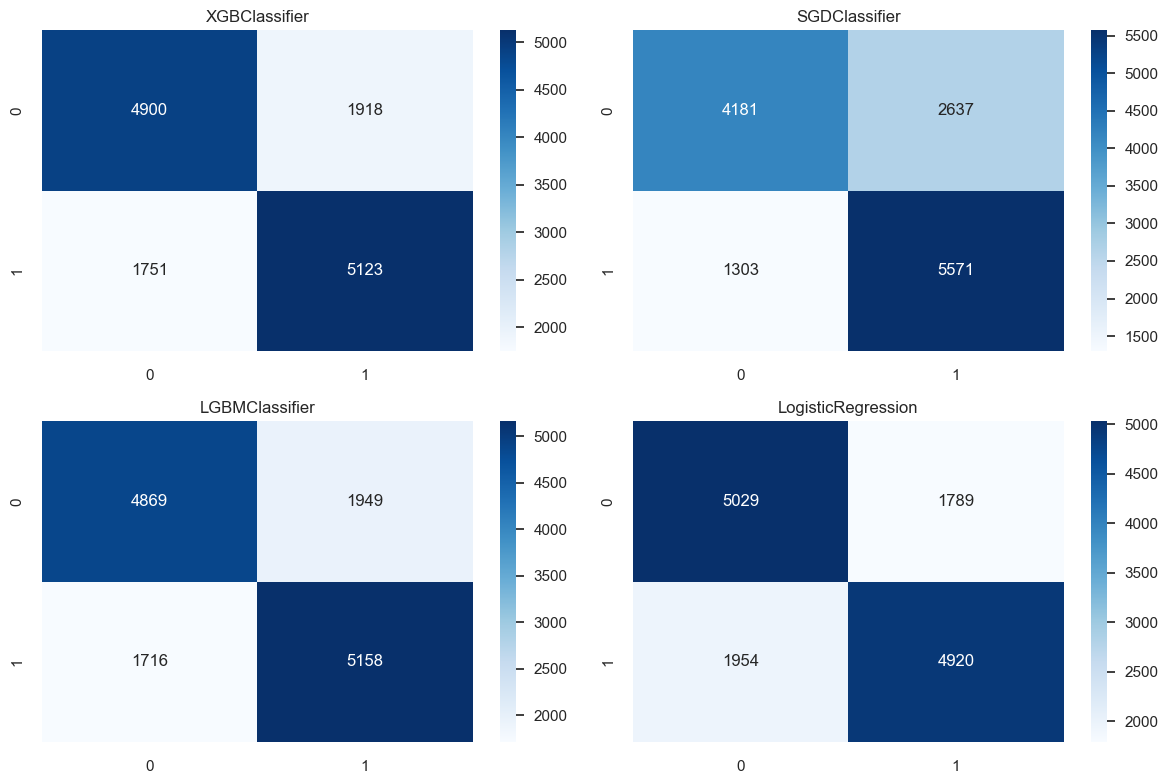

In [ ]:
threshold = 0.45
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

lista_de_modelos = [XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3),
                    SGDClassifier(loss='log_loss', random_state=SEED, n_jobs=-1), 
                    LGBMClassifier(random_state=SEED, n_jobs=-1, force_row_wise=True),
                    LogisticRegression(max_iter=220, random_state=SEED)]


for clf, ax in zip(lista_de_modelos, axes.flatten()):
    # Fit the model
    clf.fit( x_train, y_train )
    
    # Predict the probabilities
    clf_probs = clf.predict_proba( x_teste )
    
    # Keep probabilities for the positive outcome only
    probs = clf_probs[:, 1]
    
    # Apply the threshold
    y_pred = np.where(probs > threshold, 1, 0)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_teste, y_pred)
    
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(type(clf).__name__)

# Adjust subplot layout
plt.tight_layout()

# Display the plot
plt.show()

[LightGBM] [Info] Number of positive: 27628, number of negative: 27137
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 54765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504483 -> initscore=0.017932
[LightGBM] [Info] Start training from score 0.017932


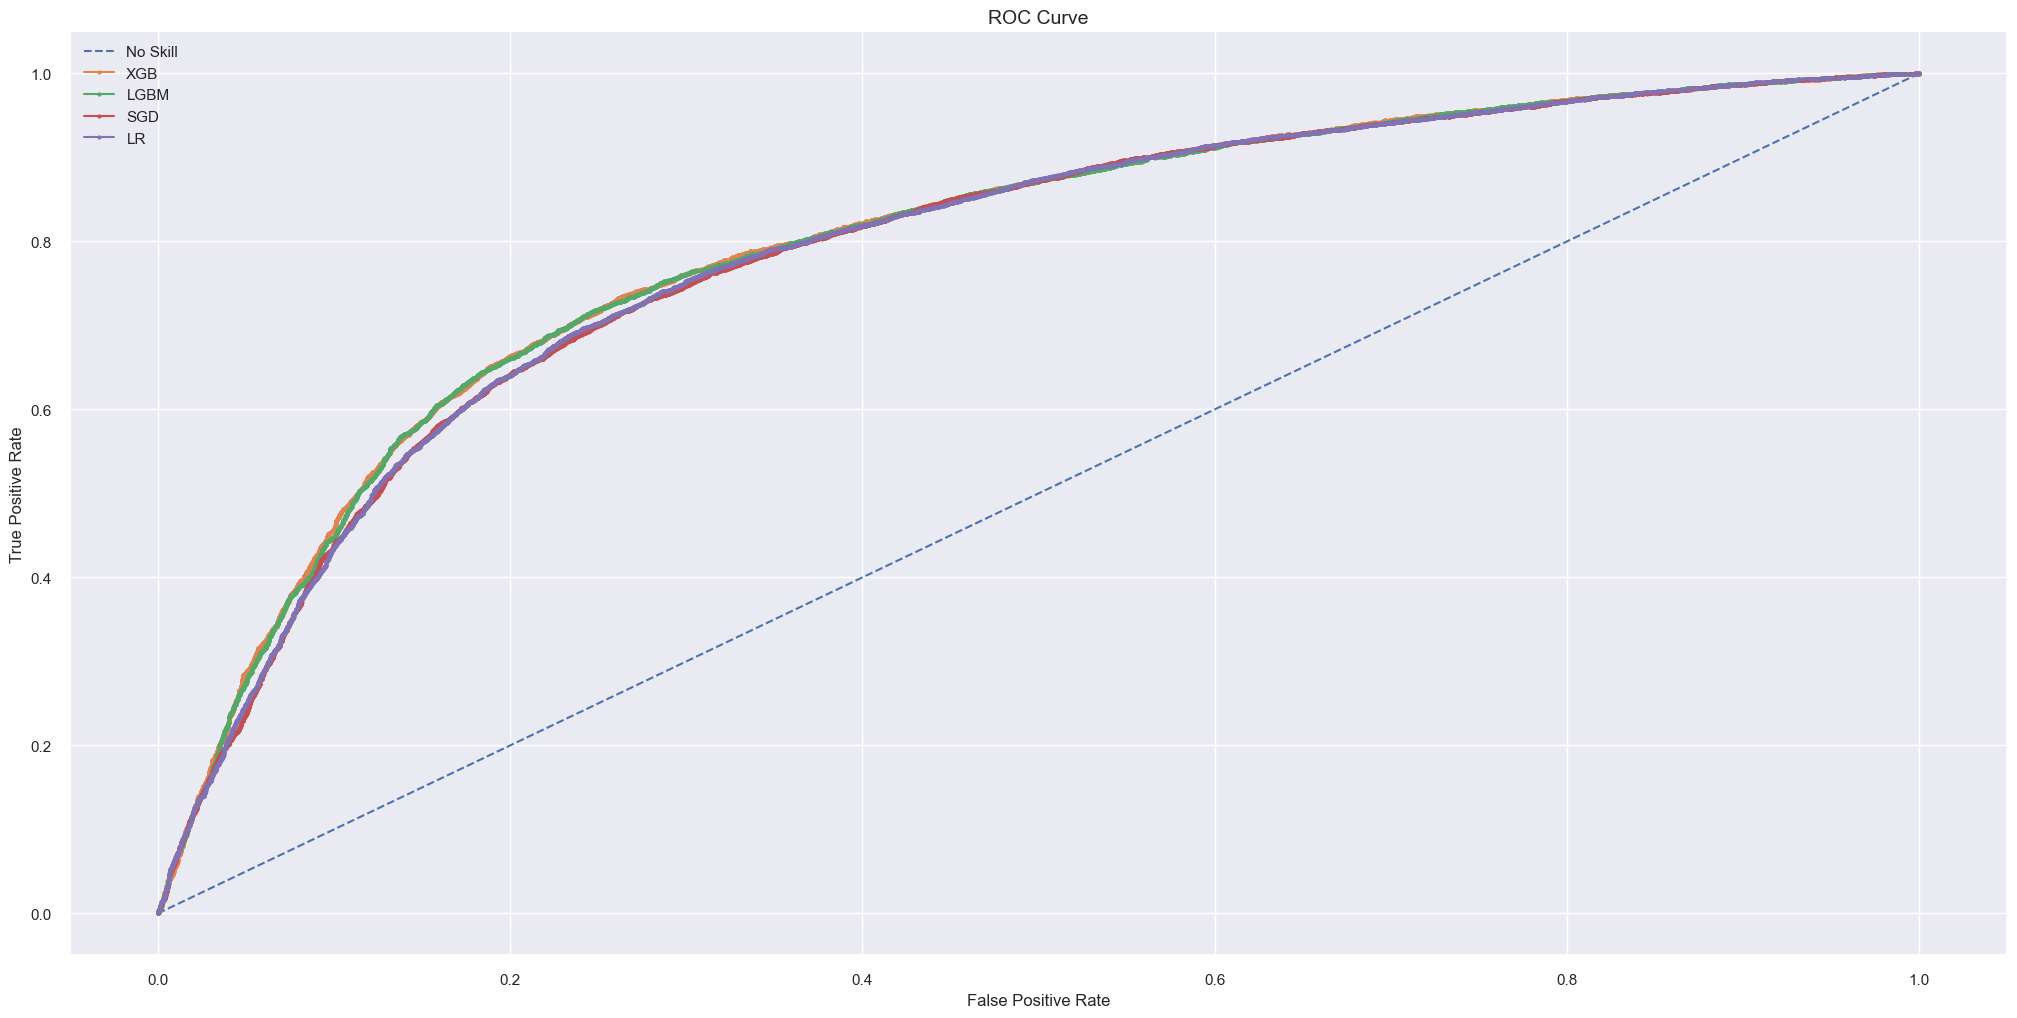

In [ ]:
# ROC Curve        

# trains the classifiers
xgb.fit( x_train, np.ravel( y_train ) )
lgbm.fit( x_train, np.ravel( y_train ) )
sgd.fit( x_train, np.ravel( y_train ) )
lr.fit( x_train, np.ravel( y_train ) )


# store the predicted probabilities for class 1
y_pred_xgb = xgb.predict_proba( x_teste )[ :,1 ]
y_pred_lgbm = lgbm.predict_proba( x_teste )[ :,1 ]
y_pred_sgd = sgd.predict_proba( x_teste )[ :,1 ]
y_pred_lr = lr.predict_proba( x_teste )[ :,1 ]

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# generate a no skill prediction (majority class)
ns_probs = [ 0 for _ in range( len( y_teste ) ) ]

# calculates the roc curves
ns_fpr, ns_tpr, _ = roc_curve( y_teste, ns_probs )
xgb_fpr, xgb_tpr, _ = roc_curve( y_teste, y_pred_xgb )
lgbm_fpr, lgbm_tpr, _ = roc_curve( y_teste, y_pred_lgbm )
sgd_fpr, sgd_tpr, _ = roc_curve( y_teste, y_pred_sgd )
lr_fpr, lr_tpr, _ = roc_curve( y_teste, y_pred_lr )

# plots the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGB')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
plt.plot(sgd_fpr, sgd_tpr, marker='.', label='SGD')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LR')
#
# sets plot features
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# displays the legend
plt.legend()

# displays the plot
plt.show()

# Fine Tuning

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Cria uma instância do GridSearchCV com o modelo XGBoost e os parâmetros definidos
grid_search = GridSearchCV(XGBClassifier(), param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(x_train, y_train)

# Imprime os melhores parâmetros encontrados
print(grid_search.best_params_)


{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}


### Final Result

In [ ]:
# # Modelo selecionado
# XGBoosting já aplica o boosting então não precisa dessa etapa.

# final_model = XGBClassifier( colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 6, n_estimators= 100, subsample= 0.8 )
final_model = XGBClassifier( colsample_bytree= 1.0, learning_rate= 0.1, max_depth= 3, n_estimators= 100, subsample= 0.8 )


final_model.fit(x_train, y_train)
y_pred = final_model.predict( x_teste )

# Calculando as métricas de avaliação com base nas previsões da validação cruzada
accuracy = accuracy_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
precision = precision_score(y_teste, y_pred)
balanced_accuracy = balanced_accuracy_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.7340052585451359
Recall: 0.7017748036077975
Precision: 0.7518703241895262
Balanced Accuracy: 0.7341376218097656
F1 Score: 0.7259593679458239


### Cros-Validation

In [ ]:
# Validação cruzada Leave One Out
kf = StratifiedKFold(n_splits = 10)

lista_de_medidas = ['precision', 'recall', 'f1']

modelo_final_cv = XGBClassifier( colsample_bytree= 1.0, learning_rate= 0.1, max_depth= 3, n_estimators= 100, subsample= 0.8 )  

kf_scores = cross_validate(modelo_final_cv, x_final, y_final, cv=kf, scoring=lista_de_medidas, n_jobs=-1)

for medida in lista_de_medidas:
    print(f"Average {medida}: {kf_scores['test_' + medida].mean():.4f} (+/- {kf_scores['test_' + medida].std() * 2:.4f})")


Average precision: 0.7455 (+/- 0.0124)
Average recall: 0.6995 (+/- 0.0126)
Average f1: 0.7217 (+/- 0.0104)


#### Final Model Evaluation

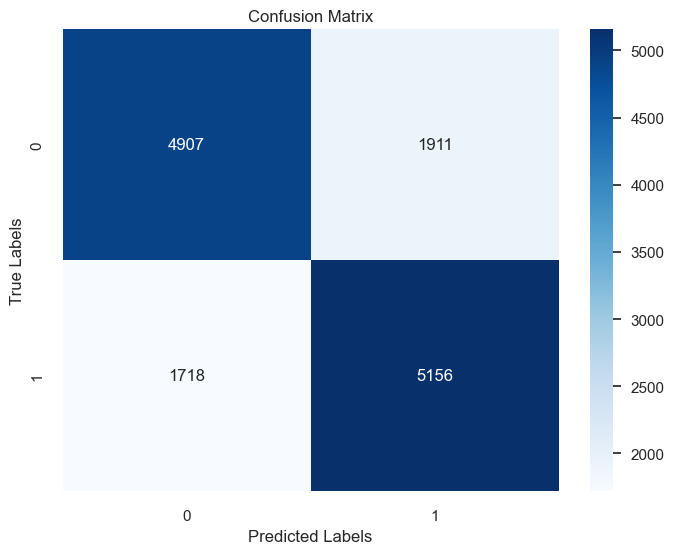

In [ ]:
threshold = 0.45

modelo_final_cv = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)

# Fit the model
modelo_final_cv.fit(x_final, y_final)

# Predict the probabilities
modelo_final_cv_probs = modelo_final_cv.predict_proba(x_teste)

# Keep probabilities for the positive outcome only
probs = modelo_final_cv_probs[:, 1]

# Apply the threshold
y_pred = np.where(probs > threshold, 1, 0)

# Calculate the confusion matrix
cm = confusion_matrix(y_teste, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Business Performance

A lembrar: "o cliente paga R$500,00 a cada 5% de acurácia acima de 50%. Por exemplo, para uma precisão de 55%, o diagnóstico custa R$500,00 para o cliente, para uma precisão de 60%, o valor é de R$ 1000,00 e assimpor diante. Se a precisão do diagnóstico for 50% o cliente não paga por ele."

In [ ]:
# Número de pacientes da base de dados: 70000

price_per_percent = 500/5
baseline = 50
num_pacients = 70000

# Medida escolhida: Precisão
model_accuracy = kf_scores['test_precision'].mean()
deviation = kf_scores['test_precision'].std() * 2

accuracy_lower = (model_accuracy - deviation) * 100
accuracy_upper = (model_accuracy + deviation) * 100

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients
average = ( amount_best + amount_worst ) /2

print(f'Best:  ${round(amount_best, 2):,.2f}')
print(f'Worst: ${round(amount_worst, 2):,.2f}')
print(f'Average: ${round(average, 2):,.2f}')


Best:  $180,490,556.97
Worst: $163,173,926.15
Average: $171,832,241.56
